In [537]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bson import ObjectId
from scipy.stats import shapiro,levene,mannwhitneyu,ttest_ind
from pymongo import MongoClient


In [538]:
client = MongoClient()
client = MongoClient('mongodb://localhost:27018/?readPreference=primary&appname=MongoDB%20Compass&ssl=false')
db = client.rhtool

# Extraire les candidats retenus et les candidats validés

In [539]:
statustrackings=db["statustrackings"]

In [540]:
ApprovedCandidates=[]
T=[]
for x in statustrackings.find({"position":ObjectId('5e2818658c00920018fa1e61')}):
    T.append(x)
    if(x['candidate'] not in ApprovedCandidates):
        ApprovedCandidates.append(x['candidate'])
        

In [541]:
print(len(ApprovedCandidates))

267


In [542]:
axeScore=db["axescores"]

In [543]:
validatedForNextStepCandidates=[]
candidateStatus=[]
sortedCandidateStatus=[]
for x in T:
    for i in T:
        if(x['candidate'] == i['candidate']):
            candidateStatus.append(i)
    sortedCandidateStatus = sorted(candidateStatus, key=lambda x: x['date'], reverse=True)
    if(str(sortedCandidateStatus[0]['statusLabel'])=="5e3005379e0fa90018499c28"):
        if(x["candidate"] not in validatedForNextStepCandidates):
            validatedForNextStepCandidates.append(x["candidate"])
    candidateStatus=[]
    sortedCandidateStatus=[]

# Extraire les steps concernées par cette offre

In [544]:
steps=[]
for x in axeScore.find({"position":ObjectId('5e2818658c00920018fa1e61')}):
    if(x['step'] not in steps):
        steps.append(x['step'])

In [545]:
print(steps)


[ObjectId('5e282cfa8c00920018fa2151'), ObjectId('5e2818658c00920018fa1e5b')]


# Extraire les scores par axes

In [546]:
def get_candidate_score(db,step_id):
    
    """ Fetch candidates score for each axis with step ObjectId as filter
    """

    query_result = db.axescores.aggregate(
        [
            {
                "$match":{
                    "step":step_id
                }
            },
            {
                "$project":{
                    "candidateId":"$candidate",
                    "step":1,
                    "position":1,
                    "axe":1,
                    "score":1

                }
            },
            {
            "$lookup":{
                "from": "axes",       
                "localField": "axe",   
                "foreignField": "_id", 
                "as": "axes_info"        
            }
            },
            { "$unwind": { "path": "$axes_info",
                        "preserveNullAndEmptyArrays": True } 
            },
            {  
                "$project":{
                    "candidateId":1,
                    "step":1,
                    "axe":1,
                    "score":1,
                    "name_fr":"$axes_info.name.fr",
                    "name_en":"$axes_info.name.en"                
                }
                
            },
            {
                "$lookup":{
                    "from": "candidates",       
                    "localField": "candidateId",   
                    "foreignField": "_id", 
                    "as": "candidate_info"        
                }
            },  
            {
            "$unwind":{ "path": "$candidate_info",
                        "preserveNullAndEmptyArrays": True }
            },
            {
                "$project":{
                    "candidateId":1,
                    "step":1,
                    "email":"$candidate_info.email",
                    "firstName":"$candidate_info.firstName",
                    "lastName":"$candidate_info.lastName",
                    "axe":1,
                    "score":1,
                    "name_fr":1,
                    "name_en":1        
                }
            },
        ]
    )

    columns = ["candidateId","step","email","firstName","lastName","axe","score","name_fr","name_en"]

    return query_result, columns

les resultats du 1 er axe

In [547]:
query_result,columns = get_candidate_score(db,steps[0])
score_pdf = pd.DataFrame(query_result,columns = columns)
score_pdf = pd.pivot_table(score_pdf,index="candidateId",columns="name_fr",values="score",aggfunc="first")

In [548]:
 print(score_pdf)

name_fr                   Adaptabilité à l'environnement, aux personnes, écoute  \
candidateId                                                                       
5e74fb1e367a4600196e35c7                                               78.0       
5e74fb4bdeef720011091d07                                               83.0       
5e74fbe1367a4600196e363b                                               79.0       
5e74fc08deef720011091d1d                                               71.0       
5e74fc4df547a200180e3a44                                               73.0       
...                                                                     ...       
5e7b5ad52556c1001820b95a                                               61.0       
5e7b5c9edce2080018fef59e                                               87.0       
5e7b6417deef72001109d04e                                               68.0       
5e7b752edce2080018ff290c                                               66.0       
5e7b

In [549]:
query_result,columns = get_candidate_score(db,steps[1])
score_pdf1 = pd.DataFrame(query_result,columns = columns)
score_pdf1 = pd.pivot_table(score_pdf1,index="candidateId",columns="name_fr",values="score",aggfunc="first")

In [550]:
print(score_pdf1)

name_fr                   Présélection
candidateId                           
5e74fb1e367a4600196e35c7           100
5e74fb4bdeef720011091d07           100
5e74fb86deef720011091d0d            60
5e74fbe1367a4600196e363b           100
5e74fc08deef720011091d1d           100
...                                ...
5ea178f98c8ab2001895c54c           100
5ea425698c8ab2001895d58c           100
5ea5131a8c8ab2001895d8a5           100
5ea58ca490eaf50018dabd94           100
5eeb30da76690f0019ff183e           100

[2437 rows x 1 columns]


In [551]:
result = pd.concat([score_pdf, score_pdf1], axis=1, join='inner')


In [552]:
result

name_fr                   Adaptabilité à l'environnement, aux personnes, écoute  \
candidateId                                                                       
5e74fb1e367a4600196e35c7                                               78.0       
5e74fb4bdeef720011091d07                                               83.0       
5e74fbe1367a4600196e363b                                               79.0       
5e74fc08deef720011091d1d                                               71.0       
5e74fc4df547a200180e3a44                                               73.0       
...                                                                     ...       
5e7b5ad52556c1001820b95a                                               61.0       
5e7b5c9edce2080018fef59e                                               87.0       
5e7b6417deef72001109d04e                                               68.0       
5e7b752edce2080018ff290c                                               66.0       
5e7b7abddce2080018ff3032                                               69.0       

name_fr                   Anglais  Expression écrite - connaissance CEO  \
candidateId                                                               
5e74fb1e367a4600196e35c7     89.0                                   0.0   
5e74fb4bdeef720011091d07    100.0                                   0.0   
5e74fbe1367a4600196e363b     92.0                                   NaN   
5e74fc08deef720011091d1d     89.0                                   0.0   
5e74fc4df547a200180e3a44     39.0                                   0.0   
...                           ...                                   ...   
5e7b5ad52556c1001820b95a     50.0                                   NaN   
5e7b5c9edce2080018fef59e     96.0                                   NaN   
5e7b6417deef72001109d04e     63.0                                   NaN   
5e7b752edce2080018ff290c     92.0                                   0.0   
5e7b7abddce2080018ff3032     42.0                                   0.0   

name_fr                   Expression écrite anglais  Gestion du stress  \
candidateId                                                              
5e74fb1e367a4600196e35c7                        0.0               80.0   
5e74fb4bdeef720011091d07                        0.0               88.0   
5e74fbe1367a4600196e363b                        0.0               65.0   
5e74fc08deef720011091d1d                        0.0               73.0   
5e74fc4df547a200180e3a44                        0.0               75.0   
...                                             ...                ...   
5e7b5ad52556c1001820b95a                        0.0               70.0   
5e7b5c9edce2080018fef59e                        0.0               55.0   
5e7b6417deef72001109d04e                        0.0               48.0   
5e7b752edce2080018ff290c                        0.0               70.0   
5e7b7abddce2080018ff3032                        0.0               73.0   

name_fr                   Leadership  Synthèse, capacité de raisonnement  \
candidateId                                                                
5e74fb1e367a4600196e35c7        34.0                                71.0   
5e74fb4bdeef720011091d07        66.0                                72.0   
5e74fbe1367a4600196e363b        28.0                                71.0   
5e74fc08deef720011091d1d        41.0                                81.0   
5e74fc4df547a200180e3a44        58.0                                61.0   
...                              ...                                 ...   
5e7b5ad52556c1001820b95a        26.0                                61.0   
5e7b5c9edce2080018fef59e        69.0                                60.0   
5e7b6417deef72001109d04e        16.0                                63.0   
5e7b752edce2080018ff290c        67.0                                74.0   
5e7b7abddce2080018ff3032        38.0                                8

In [553]:
#pour ajouter l'index ( id) comme une colone a part 
resultAxes = result.reset_index()
resultAxes


name_fr               candidateId  \
0        5e74fb1e367a4600196e35c7   
1        5e74fb4bdeef720011091d07   
2        5e74fbe1367a4600196e363b   
3        5e74fc08deef720011091d1d   
4        5e74fc4df547a200180e3a44   
..                            ...   
892      5e7b5ad52556c1001820b95a   
893      5e7b5c9edce2080018fef59e   
894      5e7b6417deef72001109d04e   
895      5e7b752edce2080018ff290c   
896      5e7b7abddce2080018ff3032   

name_fr  Adaptabilité à l'environnement, aux personnes, écoute  Anglais  \
0                                                     78.0         89.0   
1                                                     83.0        100.0   
2                                                     79.0         92.0   
3                                                     71.0         89.0   
4                                                     73.0         39.0   
..                                                     ...          ...   
892                                                   61.0         50.0   
893                                                   87.0         96.0   
894                                                   68.0         63.0   
895                                                   66.0         92.0   
896                                                   69.0         42.0   

name_fr  Expression écrite - connaissance CEO  Expression écrite anglais  \
0                                         0.0                        0.0   
1                                         0.0                        0.0   
2                                         NaN                        0.0   
3                                         0.0                        0.0   
4                                         0.0                        0.0   
..                                        ...                        ...   
892                                       NaN                        0.0   
893                                       NaN                        0.0   
894                                       NaN                        0.0   
895                                       0.0                        0.0   
896                                       0.0                        0.0   

name_fr  Gestion du stress  Leadership  Synthèse, capacité de raisonnement  \
0                     80.0        34.0                                71.0   
1                     88.0        66.0                                72.0   
2                     65.0        28.0                                71.0   
3                     73.0        41.0                                81.0   
4                     75.0        58.0                                61.0   
..                     ...         ...                                 ...   
892                   70.0        26.0                                61.0   
893                   55.0        69.0                                60.0   
894                   48.0        16.0                                63.0   
895                   70.0        67.0                                74.0   
896                   73.0        38.0                                86.0   

name_fr  Vivacité d'esprit, adaptabilité, flexibilité mentale  Présélection  
0                                                     94.0              100  
1                                                     81.0              100  
2                                                     91.0              100  
3                                                     90.0              100  
4                                                     77.0              100  
..                                                     ...              ...  
892                                                   91.0              100  
893                                                   81.0              100  
894                                                   96.0              100  
895                     

In [554]:
#detecter les candidats qui sont non rentenu pour les supprimer
toDelete=[]
for i in range(0,len(resultAxes.index)):
    if (resultAxes.iloc[i]["candidateId"]) not in ApprovedCandidates:
        toDelete.append(i)


In [555]:
resultAxes.drop(toDelete,inplace=True)

In [556]:
resultAxes

name_fr               candidateId  \
0        5e74fb1e367a4600196e35c7   
1        5e74fb4bdeef720011091d07   
3        5e74fc08deef720011091d1d   
5        5e74fc87367a4600196e365e   
8        5e74fcfddeef720011091d6e   
..                            ...   
881      5e7a842ff547a200180e8b5c   
882      5e7a8643deef720011097032   
883      5e7b000bf547a200180e8c7b   
893      5e7b5c9edce2080018fef59e   
895      5e7b752edce2080018ff290c   

name_fr  Adaptabilité à l'environnement, aux personnes, écoute  Anglais  \
0                                                     78.0         89.0   
1                                                     83.0        100.0   
3                                                     71.0         89.0   
5                                                     75.0         92.0   
8                                                     86.0         96.0   
..                                                     ...          ...   
881                                                   70.0         63.0   
882                                                   79.0         96.0   
883                                                   93.0         92.0   
893                                                   87.0         96.0   
895                                                   66.0         92.0   

name_fr  Expression écrite - connaissance CEO  Expression écrite anglais  \
0                                         0.0                        0.0   
1                                         0.0                        0.0   
3                                         0.0                        0.0   
5                                         0.0                        0.0   
8                                         0.0                        0.0   
..                                        ...                        ...   
881                                       0.0                        0.0   
882                                       0.0                        0.0   
883                                       0.0                        0.0   
893                                       NaN                        0.0   
895                                       0.0                        0.0   

name_fr  Gestion du stress  Leadership  Synthèse, capacité de raisonnement  \
0                     80.0        34.0                                71.0   
1                     88.0        66.0                                72.0   
3                     73.0        41.0                                81.0   
5                     78.0        53.0                                67.0   
8                     60.0        29.0                                73.0   
..                     ...         ...                                 ...   
881                   78.0        62.0                                84.0   
882                   83.0        92.0                                76.0   
883                   85.0        68.0                                82.0   
893                   55.0        69.0                                60.0   
895                   70.0        67.0                                74.0   

name_fr  Vivacité d'esprit, adaptabilité, flexibilité mentale  Présélection  
0                                                     94.0              100  
1                                                     81.0              100  
3                                                     90.0              100  
5                                                     93.0              100  
8                                                     98.0              100  
..                                                     ...              ...  
881                                                   98.0              100  
882                                                   91.0              100  
883                                                   95.0              100  
893                     

# Extraire les scores par minigame

In [557]:
def get_minigames_result(db,step_id):
    
    """ 
    Fetch minigame results with step ObjectId as filter
        
    """

    query_result = db.minigameresults.aggregate(
        [
        {
            "$match" : {
                "step":step_id
            }
        }, 
        {
            "$project" : {
                "candidate":1,
                "miniGame":1,
                "type":1,
                "step":1,
                "averageTime":1,
                "date":1,
                "max":1,
                "nbCorrect":1,
                "noteGlobal":1,
                "Tmax":1,
                "Tmin":1,
                "scorePonderation":1,
                "timePonderation":1,             
                "time_attempts" : "$blocks.attempts.time"
            }
        },
        {"$unwind":"$time_attempts"},
        {"$unwind":"$time_attempts"},
        {
          "$group" :
            {
              "_id" : {
                "candidate":"$candidate",
                "miniGame":"$miniGame",
                "type":"$type",
                "step":"$step",
                "averageTime":"$averageTime",
                "date":"$date",
                "max":"$max",
                "Tmax":"$Tmax",
                "Tmin":"$Tmin",
                "scorePonderation":"$scorePonderation",
                "timePonderation":"$timePonderation",  
                "nbCorrect":"$nbCorrect",
                "noteGlobal":"$noteGlobal"
              },
              "total_time_attempts": { "$sum":"$time_attempts" }
            }
         },
         {
             "$project":{
                "_id":0,
                "candidate":"$_id.candidate",
                "miniGame":"$_id.miniGame",
                "type":"$_id.type",
                "step":"$_id.step",
                "averageTime":"$_id.averageTime",
                "date":"$_id.date",
                "max":"$_id.max",
                "Tmax":"$_id.Tmax",
                "Tmin":"$_id.Tmin",
                "scorePonderation":"$_id.scorePonderation",
                "timePonderation":"$_id.timePonderation",  
                "nbCorrect":"$_id.nbCorrect",
                "noteGlobal":"$_id.noteGlobal",
                "total_time_attempts":1

             }
         },
          {
        "$lookup":{
            "from": "minigames",       
            "localField": "miniGame",   
            "foreignField": "_id", 
            "as": "minigame_info"                   
        }
        },
        {"$unwind" : "$minigame_info"},
        {
        "$project":{
            "candidate":1,
            "miniGame":1,
            "name":"$minigame_info.name",
            "version":"$minigame_info.description",
            "useTimeForScoring":"$minigame_info.useTimeForScoring",
            "type":1,
            "step":1,
            "averageTime":1,
            "date":1,
            "max":1,
            "Tmax":1,
            "Tmin":1,
            "scorePonderation":1,
            "timePonderation":1,  
            "nbCorrect":1,
            "noteGlobal":1,
            "total_time_attempts":1

        }
        },
        {
        "$lookup":{
            "from": "candidates",       
            "localField": "candidate",   
            "foreignField": "_id", 
            "as": "candidate_info"        
        }
        },
        {"$unwind" : "$candidate_info"},
        {
            "$project" : {
                "candidate":1,
                "mail":"$candidate_info.email",
                "miniGame":1,
                "name":1,
                "version":1,
                "useTimeForScoring":1,
                "type":1,
                "step":1,
                "averageTime":1,
                "date":1,
                "max":1,
                "Tmax":1,
                "Tmin":1,
                "scorePonderation":1,
                "timePonderation":1,  
                "nbCorrect":1,
                "noteGlobal":1,
                "total_time_attempts":1

            }
        }
        
        ]
    )

    columns = ["candidate","mail","miniGame","name","version","useTimeForScoring","type","step","averageTime","date","max","Tmax","Tmin","scorePonderation","timePonderation","nbCorrect","noteGlobal","total_time_attempts"] 

    return query_result, columns

In [558]:
minigameresults=db["minigameresults"]
steps1=[]
for x in minigameresults.find({"position":ObjectId('5e2818658c00920018fa1e61')}):
    if(x['step'] not in steps1):
        steps1.append(x['step'])

In [559]:
result_query,columns = get_minigames_result(db,steps1[0])
minigame_pdf = pd.DataFrame(result_query,columns=columns)
grade_minigame_pdf = (
    minigame_pdf[["candidate","name","noteGlobal"]]
    .pivot_table(index="candidate",columns=["name"],values="noteGlobal")
)

In [560]:
print(grade_minigame_pdf)

name                      cooperation  londonTowers  perspectiveTaking  \
candidate                                                                
5e74fb1e367a4600196e35c7         67.0      0.000000          57.142857   
5e74fb4bdeef720011091d07         50.0     81.439619          71.428571   
5e74fbe1367a4600196e363b         36.0     20.695389          50.000000   
5e74fc08deef720011091d1d         50.0     32.856000          28.571429   
5e74fc4df547a200180e3a44         98.0     17.763841          57.142857   
...                               ...           ...                ...   
5e7b5ad52556c1001820b95a         39.0     12.904138          28.571429   
5e7b5c9edce2080018fef59e         44.0     94.806094          78.571429   
5e7b6417deef72001109d04e         32.0      0.000000          50.000000   
5e7b752edce2080018ff290c         39.0     94.806094          28.571429   
5e7b7abddce2080018ff3032         44.0     31.427916          28.571429   

name                      taskSwitchi

In [561]:
resultGames = grade_minigame_pdf.reset_index()
resultGames

name                 candidate  cooperation  londonTowers  perspectiveTaking  \
0     5e74fb1e367a4600196e35c7         67.0      0.000000          57.142857   
1     5e74fb4bdeef720011091d07         50.0     81.439619          71.428571   
2     5e74fbe1367a4600196e363b         36.0     20.695389          50.000000   
3     5e74fc08deef720011091d1d         50.0     32.856000          28.571429   
4     5e74fc4df547a200180e3a44         98.0     17.763841          57.142857   
...                        ...          ...           ...                ...   
1040  5e7b5ad52556c1001820b95a         39.0     12.904138          28.571429   
1041  5e7b5c9edce2080018fef59e         44.0     94.806094          78.571429   
1042  5e7b6417deef72001109d04e         32.0      0.000000          50.000000   
1043  5e7b752edce2080018ff290c         39.0     94.806094          28.571429   
1044  5e7b7abddce2080018ff3032         44.0     31.427916          28.571429   

name  taskSwitching2  workMemory2  
0          93.750000    79.279279  
1          81.198855    84.684685  
2          90.536261    87.387387  
3          89.583333    92.792793  
4          76.665548    66.545111  
...              ...          ...  
1040       90.625000    73.285404  
1041       81.059962    72.233982  
1042       95.833333    82.882883  
1043       79.394269    88.053296  
1044       93.750000    97.424201  

[1045 rows x 6 columns]

In [562]:
toDelete1=[]
for i in range(0,len(resultGames.index)):
    if (resultGames.iloc[i]["candidate"]) not in ApprovedCandidates:
        toDelete1.append(i)


In [563]:
resultGames.drop(toDelete1,inplace=True)

In [564]:
resultGames

name                 candidate  cooperation  londonTowers  perspectiveTaking  \
0     5e74fb1e367a4600196e35c7         67.0      0.000000          57.142857   
1     5e74fb4bdeef720011091d07         50.0     81.439619          71.428571   
3     5e74fc08deef720011091d1d         50.0     32.856000          28.571429   
5     5e74fc87367a4600196e365e         67.0     39.825455          57.142857   
9     5e74fcfddeef720011091d6e         43.0     15.897808          92.857143   
...                        ...          ...           ...                ...   
1027  5e7a842ff547a200180e8b5c         57.0     67.604938          35.714286   
1028  5e7a8643deef720011097032         83.0    100.000000          42.857143   
1029  5e7b000bf547a200180e8c7b         79.0     57.017909          92.857143   
1041  5e7b5c9edce2080018fef59e         44.0     94.806094          78.571429   
1043  5e7b752edce2080018ff290c         39.0     94.806094          28.571429   

name  taskSwitching2  workMemory2  
0          93.750000    79.279279  
1          81.198855    84.684685  
3          89.583333    92.792793  
5          92.708333    87.387387  
9          97.916667    70.739115  
...              ...          ...  
1027       97.916667    94.319563  
1028       90.625000    74.774775  
1029       94.791667    82.438448  
1041       81.059962    72.233982  
1043       79.394269    88.053296  

[267 rows x 6 columns]

# extraire les resultats pour les questionnaires

In [565]:
def get_questionnaire_result(db,step_id):
    
    """ 
    Fetch questionnaire results with step Objectid as filter
        
    """

    query_result = db.questionnaireresults.aggregate(
        [
           {
               "$match" : {
                   "step":step_id
               }
           }, 
           {
               "$project" : {
                "candidate":1,
                "questionnaire":1,
                "step":1,
                "enter":1,
                "exit":1,
                "averageTime":1,
                "noteGlobal":1

               }
           },
            {
            "$lookup":{
                "from": "questionnaires",       
                "localField": "questionnaire",   
                "foreignField": "_id", 
                "as": "questionnaire_info"        
            }
            },
            {"$unwind" : "$questionnaire_info"},
            {"$project" : {
                "candidate":1,
                "questionnaire":1,
                "step":1,
                "enter":1,
                "exit":1,
                "averageTime":1,
                "noteGlobal":1,
                "useTimeForScoring":"$questionnaire_info.useTimeForScoring",
                "questionnaire_name":"$questionnaire_info.name"
            }},
            {
            "$lookup":{
                "from": "candidates",       
                "localField": "candidate",   
                "foreignField": "_id", 
                "as": "candidate_info"        
            }
            },
            {"$unwind" : "$candidate_info"},
            {
                "$project" : {
                    "candidate":1,
                    "mail":"$candidate_info.email",
                    "questionnaire":1,
                    "step":1,
                    "questionnaire_name":1,
                    "useTimeForScoring":1,
                    "enter":1,
                    "exit":1,
                    "averageTime":1,
                    "noteGlobal":1
                }
            }

        ]
    )


    columns = [ "candidate",
                "mail",
                "questionnaire",
                "step",
                "questionnaire_name",
                "useTimeForScoring",
                "enter",
                "exit",
                "averageTime",
                "noteGlobal"]

    return query_result,columns

In [566]:
questionnaireresults=db["questionnaireresults"]
steps2=[]
for x in questionnaireresults.find({"position":ObjectId('5e2818658c00920018fa1e61')}):
    if(x['step'] not in steps2):
        steps2.append(x['step'])

In [567]:
print(steps2)

[ObjectId('5e2818658c00920018fa1e5b'), ObjectId('5e282cfa8c00920018fa2151')]


In [568]:
result_query,columns = get_questionnaire_result(db,steps2[0])
questionnaire_pdf = pd.DataFrame(result_query,columns=columns)
grade_questionnaire_pdf = (
    questionnaire_pdf[["candidate","questionnaire_name","noteGlobal"]]
    .pivot_table(index="candidate",columns=["questionnaire_name"],values="noteGlobal")
    
)

In [569]:
result_query,columns = get_questionnaire_result(db,steps2[1])
questionnaire_pdf1 = pd.DataFrame(result_query,columns=columns)
grade_questionnaire_pdf1 = (
    questionnaire_pdf1[["candidate","questionnaire_name","noteGlobal"]]
    .pivot_table(index="candidate",columns=["questionnaire_name"],values="noteGlobal")
    
)

In [570]:
grade_questionnaire_pdf = grade_questionnaire_pdf.reset_index()
toDelete2=[]
for i in range(0,len(grade_questionnaire_pdf.index)):
    if (grade_questionnaire_pdf.iloc[i]["candidate"]) not in ApprovedCandidates:
        toDelete2.append(i)

In [571]:
grade_questionnaire_pdf.drop(toDelete2,inplace=True)

In [572]:
grade_questionnaire_pdf

questionnaire_name                 candidate  \
0                   5e74fb1e367a4600196e35c7   
1                   5e74fb4bdeef720011091d07   
4                   5e74fc08deef720011091d1d   
7                   5e74fc87367a4600196e365e   
17                  5e74fcfddeef720011091d6e   
...                                      ...   
2307                5e7a842ff547a200180e8b5c   
2308                5e7a8643deef720011097032   
2315                5e7b000bf547a200180e8c7b   
2342                5e7b5c9edce2080018fef59e   
2345                5e7b752edce2080018ff290c   

questionnaire_name  Questionnaire préliminaire - CEO for One Month (Adecco)  
0                                                                 100        
1                                                                 100        
4                                                                 100        
7                                                                 100        
17                                                                100        
...                                                               ...        
2307                                                              100        
2308                                                              100        
2315                                                              100        
2342                                                              100        
2345                                                              100        

[267 rows x 2 columns]

In [573]:
grade_questionnaire_pdf1 = grade_questionnaire_pdf1.reset_index()
toDelete3=[]
for i in range(0,len(grade_questionnaire_pdf1.index)):
    if (grade_questionnaire_pdf1.iloc[i]["candidate"]) not in ApprovedCandidates:
        toDelete3.append(i)

In [574]:
grade_questionnaire_pdf1.drop(toDelete3,inplace=True)
grade_questionnaire_pdf1

questionnaire_name                 candidate  \
0                   5e74fb1e367a4600196e35c7   
1                   5e74fb4bdeef720011091d07   
3                   5e74fc08deef720011091d1d   
5                   5e74fc87367a4600196e365e   
9                   5e74fcfddeef720011091d6e   
...                                      ...   
1013                5e7a842ff547a200180e8b5c   
1014                5e7a8643deef720011097032   
1015                5e7b000bf547a200180e8c7b   
1027                5e7b5c9edce2080018fef59e   
1029                5e7b752edce2080018ff290c   

questionnaire_name  Compréhension écrite en anglais - variante 4  \
0                                                           80.0   
1                                                          100.0   
3                                                           80.0   
5                                                          100.0   
9                                                          100.0   
...                                                          ...   
1013                                                       100.0   
1014                                                       100.0   
1015                                                       100.0   
1027                                                       100.0   
1029                                                       100.0   

questionnaire_name  Esprit déductif - variante 1 version 4 (R&D)  \
0                                                      63.658279   
1                                                      59.023072   
3                                                      68.750000   
5                                                      46.875000   
9                                                      75.000000   
...                                                          ...   
1013                                                   73.073575   
1014                                                   77.114327   
1015                                                   81.250000   
1027                                                   46.875000   
1029                                                   60.587262   

questionnaire_name  Feedback candidat - version 4 (courte) (Adecco)  \
0                                                              75.0   
1                                                             100.0   
3                                                             100.0   
5                                                              75.0   
9                                                              75.0   
...                                                             ...   
1013                                                           75.0   
1014                                                           75.0   
1015                                                          100.0   
1027                                                          100.0   
1029                                                           50.0   

questionnaire_name  Gestion du stress (R&D) - Version 1  \
0                                                  80.0   
1                                                  87.5   
3                                                  72.5   
5                                                  77.5   
9                                                  60.0   
...                                                 ...   
1013                                               77.5   
1014                                               82.5   
1015                                               85.0   
1027                                               55.0   
1029                                               70.0   

questionnaire_name  Grammaire en anglais - variante 2  \
0                                                87.5   
1                                               100.0   
3                                                87.5   

In [575]:
resultQuestionnaire = grade_questionnaire_pdf.join(grade_questionnaire_pdf1.set_index('candidate'), on='candidate')


In [576]:
resultQuestionnaire

questionnaire_name                 candidate  \
0                   5e74fb1e367a4600196e35c7   
1                   5e74fb4bdeef720011091d07   
4                   5e74fc08deef720011091d1d   
7                   5e74fc87367a4600196e365e   
17                  5e74fcfddeef720011091d6e   
...                                      ...   
2307                5e7a842ff547a200180e8b5c   
2308                5e7a8643deef720011097032   
2315                5e7b000bf547a200180e8c7b   
2342                5e7b5c9edce2080018fef59e   
2345                5e7b752edce2080018ff290c   

questionnaire_name  Questionnaire préliminaire - CEO for One Month (Adecco)  \
0                                                                 100         
1                                                                 100         
4                                                                 100         
7                                                                 100         
17                                                                100         
...                                                               ...         
2307                                                              100         
2308                                                              100         
2315                                                              100         
2342                                                              100         
2345                                                              100         

questionnaire_name  Compréhension écrite en anglais - variante 4  \
0                                                           80.0   
1                                                          100.0   
4                                                           80.0   
7                                                          100.0   
17                                                         100.0   
...                                                          ...   
2307                                                       100.0   
2308                                                       100.0   
2315                                                       100.0   
2342                                                       100.0   
2345                                                       100.0   

questionnaire_name  Esprit déductif - variante 1 version 4 (R&D)  \
0                                                      63.658279   
1                                                      59.023072   
4                                                      68.750000   
7                                                      46.875000   
17                                                     75.000000   
...                                                          ...   
2307                                                   73.073575   
2308                                                   77.114327   
2315                                                   81.250000   
2342                                                   46.875000   
2345                                                   60.587262   

questionnaire_name  Feedback candidat - version 4 (courte) (Adecco)  \
0                                                              75.0   
1                                                             100.0   
4                                                             100.0   
7                                                              75.0   
17                                                             75.0   
...                                                             ...   
2307                                                           75.0   
2308                                                           75.0   
2315                                                          100.0   
2342                                                          100.0   
2345                                                       

# all results

In [577]:
#finalResult = pd.concat([resultQuestionnaire, resultGames], axis=1, join='inner')
finalResult  = resultQuestionnaire.join(resultGames.set_index('candidate'), on='candidate')
finalResult=finalResult.join(resultAxes.set_index('candidateId'), on='candidate')

In [578]:
finalResult

candidate  \
0     5e74fb1e367a4600196e35c7   
1     5e74fb4bdeef720011091d07   
4     5e74fc08deef720011091d1d   
7     5e74fc87367a4600196e365e   
17    5e74fcfddeef720011091d6e   
...                        ...   
2307  5e7a842ff547a200180e8b5c   
2308  5e7a8643deef720011097032   
2315  5e7b000bf547a200180e8c7b   
2342  5e7b5c9edce2080018fef59e   
2345  5e7b752edce2080018ff290c   

      Questionnaire préliminaire - CEO for One Month (Adecco)  \
0                                                   100         
1                                                   100         
4                                                   100         
7                                                   100         
17                                                  100         
...                                                 ...         
2307                                                100         
2308                                                100         
2315                                                100         
2342                                                100         
2345                                                100         

      Compréhension écrite en anglais - variante 4  \
0                                             80.0   
1                                            100.0   
4                                             80.0   
7                                            100.0   
17                                           100.0   
...                                            ...   
2307                                         100.0   
2308                                         100.0   
2315                                         100.0   
2342                                         100.0   
2345                                         100.0   

      Esprit déductif - variante 1 version 4 (R&D)  \
0                                        63.658279   
1                                        59.023072   
4                                        68.750000   
7                                        46.875000   
17                                       75.000000   
...                                            ...   
2307                                     73.073575   
2308                                     77.114327   
2315                                     81.250000   
2342                                     46.875000   
2345                                     60.587262   

      Feedback candidat - version 4 (courte) (Adecco)  \
0                                                75.0   
1                                               100.0   
4                                               100.0   
7                                                75.0   
17                                               75.0   
...                                               ...   
2307                                             75.0   
2308                                             75.0   
2315                                            100.0   
2342                                            100.0   
2345                                             50.0   

      Gestion du stress (R&D) - Version 1  Grammaire en anglais - variante 2  \
0                                    80.0                               87.5   
1                                    87.5                              100.0   
4                                    72.5                               87.5   
7                                    77.5                               75.0   
17                                   60.0                               87.5   
...                                   ...                                ...   
2307                                 77.5                               87.5   
2308                                 82.5                               87.5   
2315                                 85.0                               75.0   
2342                                 55.0       

In [579]:
df = pd.DataFrame(columns = ['CandidateId',"Selected"])  

In [580]:
for x in ApprovedCandidates:
    if x in validatedForNextStepCandidates:
        df.loc[-1] = [x, "true"]
        df.index = df.index + 1
    else:
        df.loc[-1] = [x, "false"]
        df.index = df.index + 1

In [581]:
df

CandidateId Selected
266  5e78b0d5367a4600196e75c0    false
265  5e75009c367a4600196e384e    false
264  5e74ff06deef720011091e32    false
263  5e75f4dcf547a200180e5af4     true
262  5e752d38deef7200110933f6    false
..                        ...      ...
4    5e78a81ef547a200180e78dc    false
3    5e7a12ffdeef720011096887     true
2    5e75ec49f547a200180e5956    false
1    5e7b752edce2080018ff290c     true
0    5e772306deef720011094b64    false

[267 rows x 2 columns]

In [582]:
final=df.join(finalResult.set_index('candidate'), on='CandidateId')

In [583]:
final

CandidateId Selected  \
266  5e78b0d5367a4600196e75c0    false   
265  5e75009c367a4600196e384e    false   
264  5e74ff06deef720011091e32    false   
263  5e75f4dcf547a200180e5af4     true   
262  5e752d38deef7200110933f6    false   
..                        ...      ...   
4    5e78a81ef547a200180e78dc    false   
3    5e7a12ffdeef720011096887     true   
2    5e75ec49f547a200180e5956    false   
1    5e7b752edce2080018ff290c     true   
0    5e772306deef720011094b64    false   

     Questionnaire préliminaire - CEO for One Month (Adecco)  \
266                                                100         
265                                                100         
264                                                100         
263                                                100         
262                                                100         
..                                                 ...         
4                                                  100         
3                                                  100         
2                                                  100         
1                                                  100         
0                                                  100         

     Compréhension écrite en anglais - variante 4  \
266                                         100.0   
265                                         100.0   
264                                         100.0   
263                                         100.0   
262                                         100.0   
..                                            ...   
4                                           100.0   
3                                           100.0   
2                                           100.0   
1                                           100.0   
0                                           100.0   

     Esprit déductif - variante 1 version 4 (R&D)  \
266                                     61.988377   
265                                     60.937500   
264                                     54.177632   
263                                     62.500000   
262                                     74.938989   
..                                            ...   
4                                       75.747807   
3                                       49.930190   
2                                       57.036367   
1                                       60.587262   
0                                       52.952632   

     Feedback candidat - version 4 (courte) (Adecco)  \
266                                            100.0   
265                                             75.0   
264                                             75.0   
263                                            100.0   
262                                            100.0   
..                                               ...   
4                                              100.0   
3                                               75.0   
2                                              100.0   
1                                               50.0   
0                                              100.0   

     Gestion du stress (R&D) - Version 1  Grammaire en anglais - variante 2  \
266                                 62.5                               50.0   
265                                 85.0                               62.5   
264                                 85.0                              100.0   
263                                 80.0                               87.5   
262                                 80.0                              100.0   
..                                   ...                                ...   
4                                   85.0                               75.0   
3                                   72.5                               62.5   
2                                   87.5                               75.0   
1      

# Analyse des resultats

In [584]:
#get column names
for i in final :
    print(i)

CandidateId
Selected
Questionnaire préliminaire - CEO for One Month (Adecco)
Compréhension écrite en anglais - variante 4
Esprit déductif - variante 1 version 4 (R&D)
Feedback candidat - version 4 (courte) (Adecco)
Gestion du stress (R&D) - Version 1
Grammaire en anglais - variante 2
Niveau Anglais CERL (Adecco)
Questionnaire - Expression écrite Anglais (Adecco)
Questionnaire - Texte libre Question CEO (Adecco)
Reconnaissance d'expressions faciales - version 4 (courte) (R&D)
Smartbehaviour - version 4 (R&D)
cooperation
londonTowers
perspectiveTaking
taskSwitching2
workMemory2
Adaptabilité à l'environnement, aux personnes, écoute
Anglais
Expression écrite - connaissance CEO
Expression écrite anglais
Gestion du stress
Leadership
Synthèse, capacité de raisonnement
Vivacité d'esprit, adaptabilité, flexibilité mentale
Présélection


Questionnaire préliminaire - CEO for One Month (Adecco)

# Analyse statistqiues

# Questionnaire préliminaire - CEO for One Month (Adecco)

In [585]:
QuestionnaireRetenu=[]
QuestionnaireNonRetenu=[]
dataQuestionnaire=[]
for i in range(0,267):
    dataQuestionnaire.append(final.iloc[i]["Questionnaire préliminaire - CEO for One Month (Adecco)"])

    if (final.iloc[i]["Selected"]=="true"):
        QuestionnaireRetenu.append(final.iloc[i]["Questionnaire préliminaire - CEO for One Month (Adecco)"])
    else : QuestionnaireNonRetenu.append(final.iloc[i]["Questionnaire préliminaire - CEO for One Month (Adecco)"])


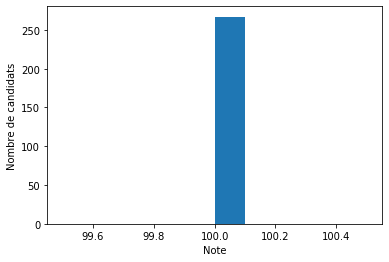

In [586]:
plt.hist(dataQuestionnaire)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()




In [587]:
shapiro(QuestionnaireRetenu)



/Users/oussamasassi/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


(1.0, 1.0)

In [588]:
shapiro(QuestionnaireNonRetenu)


(1.0, 1.0)

In [589]:
levene(QuestionnaireRetenu,QuestionnaireNonRetenu,center="mean")

/Users/oussamasassi/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2369: RuntimeWarning: invalid value encountered in double_scalars
  W = numer / denom


LeveneResult(statistic=nan, pvalue=nan)

In [590]:
ttestQuestionnaire= ttest_ind(QuestionnaireRetenu,QuestionnaireNonRetenu )

In [591]:
ttestQuestionnaire

Ttest_indResult(statistic=nan, pvalue=nan)

# Compréhension écrite en anglais - variante 4

In [592]:
ComprehensionAngRetenu=[]
ComprehensionAngNonRetenu=[]
dataComprehension=[]

for i in range(0,267):
    dataComprehension.append(final.iloc[i]["Compréhension écrite en anglais - variante 4"])

    if (final.iloc[i]["Selected"]=="true"):
        ComprehensionAngRetenu.append(final.iloc[i]["Compréhension écrite en anglais - variante 4"])
    else : ComprehensionAngNonRetenu.append(final.iloc[i]["Compréhension écrite en anglais - variante 4"])




In [593]:
shapiro(ComprehensionAngRetenu)




(0.5428114533424377, 2.1598477875444354e-14)

In [594]:
shapiro(ComprehensionAngNonRetenu)


(0.5025969743728638, 1.0008369812403982e-22)

In [595]:
levene(ComprehensionAngRetenu,ComprehensionAngNonRetenu,center="mean")

LeveneResult(statistic=9.051573900663873e-05, pvalue=0.9924162182689169)

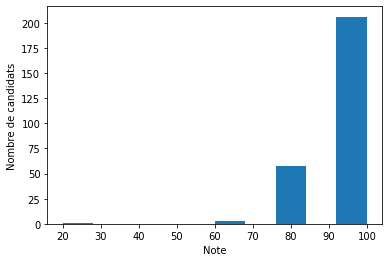

In [596]:
plt.hist(dataComprehension)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()


In [597]:
utestComprehension= mannwhitneyu(ComprehensionAngRetenu,ComprehensionAngNonRetenu)

In [598]:
utestComprehension
# pas de difference de moyenne 

MannwhitneyuResult(statistic=7467.0, pvalue=0.48816239703160647)

# Esprit déductif - variante 1 version 4 (R&D)

In [599]:
EspritDeductifRetenu=[]
EspritDeductifNonRetenu=[]
dataEspritDeductif=[]

for i in range(0,267):
    dataEspritDeductif.append(final.iloc[i]["Esprit déductif - variante 1 version 4 (R&D)"])

    if (final.iloc[i]["Selected"]=="true"):
        EspritDeductifRetenu.append(final.iloc[i]["Esprit déductif - variante 1 version 4 (R&D)"])
    else : EspritDeductifNonRetenu.append(final.iloc[i]["Esprit déductif - variante 1 version 4 (R&D)"])

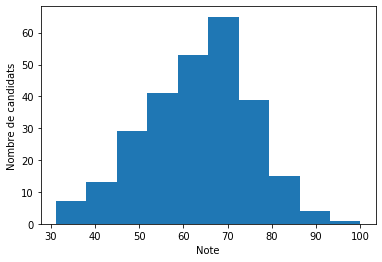

In [600]:
plt.hist(dataEspritDeductif)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()


In [601]:
shapiro(EspritDeductifRetenu)


(0.9871163964271545, 0.606168806552887)

In [602]:
shapiro(EspritDeductifNonRetenu)


(0.9782390594482422, 0.005140756722539663)

In [603]:
levene(EspritDeductifRetenu,EspritDeductifNonRetenu,center="mean")

LeveneResult(statistic=0.2771046693188324, pvalue=0.5990455297631443)

In [604]:
utestEspritDeductif= mannwhitneyu(EspritDeductifRetenu,EspritDeductifNonRetenu)

In [605]:
utestEspritDeductif

MannwhitneyuResult(statistic=7201.5, pvalue=0.31522868123107906)

# Feedback candidat - version 4 (courte) (Adecco)

In [606]:

FeedBackRetenu=[]
FeedBackNonRetenu=[]
dataFeedBack=[]
for i in range(0,267):
    dataFeedBack.append(final.iloc[i]["Feedback candidat - version 4 (courte) (Adecco)"])

    if (final.iloc[i]["Selected"]=="true"):
        FeedBackRetenu.append(final.iloc[i]["Feedback candidat - version 4 (courte) (Adecco)"])
    else : FeedBackNonRetenu.append(final.iloc[i]["Feedback candidat - version 4 (courte) (Adecco)"])

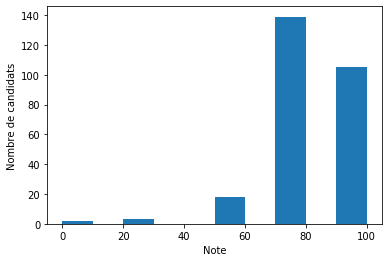

In [607]:
plt.hist(dataFeedBack)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()


In [608]:
shapiro(FeedBackRetenu)

(0.726601243019104, 6.619331471835466e-11)

In [609]:
shapiro(FeedBackNonRetenu)

(0.7629162669181824, 4.3972037272680255e-16)

In [610]:
levene(FeedBackRetenu,FeedBackNonRetenu ,center="mean")

LeveneResult(statistic=0.8187789756743592, pvalue=0.36635930977923514)

In [611]:
utestFeedbackCandidat= mannwhitneyu(FeedBackRetenu,FeedBackNonRetenu)
utestFeedbackCandidat

MannwhitneyuResult(statistic=7317.5, pvalue=0.37684327490619585)

# Gestion du stress (R&D) - Version 1

In [612]:

StressRetenu=[]
StressNonRetenu=[]
dataGestionStress=[]

for i in range(0,267):
    dataGestionStress.append(final.iloc[i]["Gestion du stress (R&D) - Version 1"])

    if (final.iloc[i]["Selected"]=="true"):
        StressRetenu.append(final.iloc[i]["Gestion du stress (R&D) - Version 1"])
    else : StressNonRetenu.append(final.iloc[i]["Gestion du stress (R&D) - Version 1"])

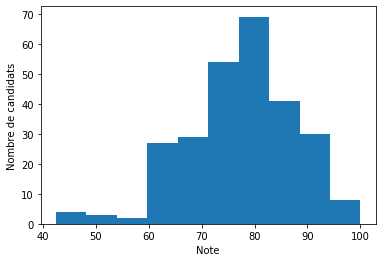

In [613]:
plt.hist(dataGestionStress)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()


In [614]:
shapiro(StressRetenu)

(0.969456672668457, 0.05240272358059883)

In [615]:
shapiro(StressNonRetenu)

(0.9747586250305176, 0.001827926840633154)

In [616]:
levene(StressRetenu,StressNonRetenu,center="mean")

LeveneResult(statistic=0.05938666176825288, pvalue=0.807656533908041)

In [617]:
utestStress= mannwhitneyu(StressRetenu,StressNonRetenu)
utestStress

MannwhitneyuResult(statistic=7115.0, pvalue=0.263474132004587)

# Grammaire en anglais - variante 2

In [618]:
GrammaireAngRetenu=[]
GrammaireAngNonRetenu=[]
dataGrammaire=[]
for i in range(0,267):
    dataGrammaire.append(final.iloc[i]["Grammaire en anglais - variante 2"])

    if (final.iloc[i]["Selected"]=="true"):
        GrammaireAngRetenu.append(final.iloc[i]["Grammaire en anglais - variante 2"])
    else : GrammaireAngNonRetenu.append(final.iloc[i]["Grammaire en anglais - variante 2"])

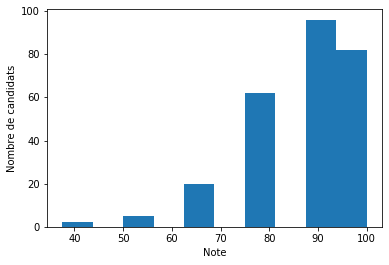

In [619]:
plt.hist(dataGrammaire)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()


In [620]:
shapiro(GrammaireAngRetenu)

(0.8387051820755005, 6.889617765182265e-08)

In [621]:
shapiro(GrammaireAngNonRetenu)

(0.8659214973449707, 8.16161808275817e-12)

In [622]:
levene (GrammaireAngRetenu,GrammaireAngNonRetenu,center="mean")

LeveneResult(statistic=0.5125196212755213, pvalue=0.4746805106660247)

In [623]:
utestGrammaireAng= mannwhitneyu(GrammaireAngRetenu, GrammaireAngNonRetenu)
utestGrammaireAng

MannwhitneyuResult(statistic=6710.0, pvalue=0.08161160960383418)

# Niveau Anglais CERL (Adecco)

In [624]:
AngAdeccoRetenu=[]
AngAdeccoNonRetenu=[]
dataAngAdecco=[]
for i in range(0,267):
    dataAngAdecco.append(final.iloc[i]["Niveau Anglais CERL (Adecco)"])

    if (final.iloc[i]["Selected"]=="true"):
        AngAdeccoRetenu.append(final.iloc[i]["Niveau Anglais CERL (Adecco)"])
    else : AngAdeccoNonRetenu.append(final.iloc[i]["Niveau Anglais CERL (Adecco)"])

In [625]:
shapiro(AngAdeccoRetenu)

(0.28974252939224243, 8.241184726434176e-18)

In [626]:
shapiro(AngAdeccoNonRetenu)

(0.440809965133667, 6.874344553957591e-24)

In [627]:
levene(AngAdeccoRetenu,AngAdeccoNonRetenu,center="mean")

LeveneResult(statistic=16.213713141118877, pvalue=7.392912389732934e-05)

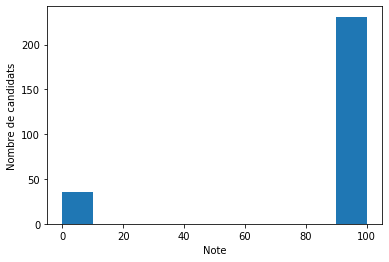

In [628]:
plt.hist(dataAngAdecco)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()



In [629]:
utestAngAdecco= mannwhitneyu(AngAdeccoRetenu, AngAdeccoNonRetenu)
utestAngAdecco

MannwhitneyuResult(statistic=6841.0, pvalue=0.03093147860272651)

# Questionnaire - Expression écrite Anglais (Adecco)

In [630]:
QuesExpressionEcriteAngRetenu=[]
QuesExpressionEcriteAngNonRetenu=[]
dataQuesExpressionEcriteAng=[]
for i in range(0,267):
    dataQuesExpressionEcriteAng.append(final.iloc[i]["Questionnaire - Expression écrite Anglais (Adecco)"])
    if (final.iloc[i]["Selected"]=="true"):
        QuesExpressionEcriteAngRetenu.append(final.iloc[i]["Questionnaire - Expression écrite Anglais (Adecco)"])
    else : QuesExpressionEcriteAngNonRetenu.append(final.iloc[i]["Questionnaire - Expression écrite Anglais (Adecco)"])

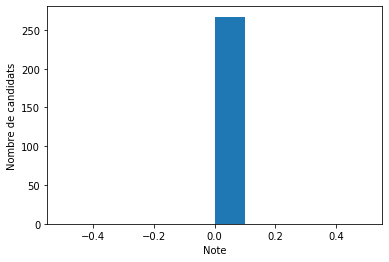

In [631]:
plt.hist(dataQuesExpressionEcriteAng)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()



In [632]:
shapiro(QuesExpressionEcriteAngRetenu)

(1.0, 1.0)

In [633]:
shapiro(QuesExpressionEcriteAngNonRetenu)

(1.0, 1.0)

In [634]:
levene(QuesExpressionEcriteAngRetenu,QuesExpressionEcriteAngNonRetenu,center="mean")

LeveneResult(statistic=nan, pvalue=nan)

In [635]:
ttestQuesExpressionEcrite= ttest_ind(QuesExpressionEcriteAngRetenu, QuesExpressionEcriteAngNonRetenu)
ttestQuesExpressionEcrite

Ttest_indResult(statistic=nan, pvalue=nan)

# Questionnaire - Texte libre Question CEO (Adecco)

In [636]:
QuesTexteLibreCeoRetenu=[]
QuesTexteLibreCeoNonRetenu=[]
dataQuesTexteLibreCeo=[]
for i in range(0,267):
    dataQuesTexteLibreCeo.append(final.iloc[i]["Questionnaire - Texte libre Question CEO (Adecco)"])
    if (final.iloc[i]["Selected"]=="true"):
        QuesTexteLibreCeoRetenu.append(final.iloc[i]["Questionnaire - Texte libre Question CEO (Adecco)"])
    else : QuesTexteLibreCeoNonRetenu.append(final.iloc[i]["Questionnaire - Texte libre Question CEO (Adecco)"])


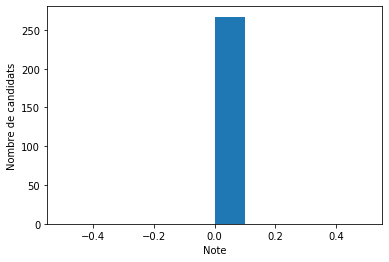

In [637]:
plt.hist(dataQuesTexteLibreCeo)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()



In [638]:
shapiro(QuesTexteLibreCeoRetenu)

(1.0, 1.0)

In [639]:
shapiro(QuesTexteLibreCeoNonRetenu)

(1.0, 1.0)

In [640]:
levene(QuesTexteLibreCeoRetenu,QuesTexteLibreCeoNonRetenu,center="mean")

LeveneResult(statistic=nan, pvalue=nan)

In [641]:
ttestQuesTexteLibreCeo= ttest_ind(QuesTexteLibreCeoRetenu, QuesTexteLibreCeoNonRetenu)
ttestQuesTexteLibreCeo

Ttest_indResult(statistic=nan, pvalue=nan)

# Reconnaissance d'expressions faciales - version 4 (courte) (R&D)

In [642]:
ReconnaissanceFacialRetenu=[]
ReconnaissanceFacialNonRetenu=[]
dataReconnaissanceFacial=[]
for i in range(0,267):
    dataReconnaissanceFacial.append(final.iloc[i]["Reconnaissance d'expressions faciales - version 4 (courte) (R&D)"])
    if (final.iloc[i]["Selected"]=="true"):
        ReconnaissanceFacialRetenu.append(final.iloc[i]["Reconnaissance d'expressions faciales - version 4 (courte) (R&D)"])
    else :ReconnaissanceFacialNonRetenu.append(final.iloc[i]["Reconnaissance d'expressions faciales - version 4 (courte) (R&D)"])


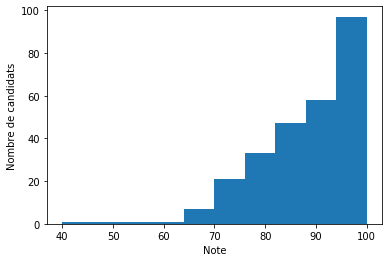

In [643]:
plt.hist(dataReconnaissanceFacial)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()



In [644]:
shapiro(ReconnaissanceFacialRetenu)

(0.9246662259101868, 0.0001590625470271334)

In [645]:
shapiro(ReconnaissanceFacialNonRetenu)

(0.8828663229942322, 6.558381615562325e-11)

In [646]:
levene(ReconnaissanceFacialRetenu,ReconnaissanceFacialNonRetenu,center="mean")

LeveneResult(statistic=0.03120717590913442, pvalue=0.8599139078238833)

In [647]:
utestReconnaissanceFacial= mannwhitneyu(ReconnaissanceFacialRetenu, ReconnaissanceFacialNonRetenu)
utestReconnaissanceFacial

MannwhitneyuResult(statistic=7264.5, pvalue=0.3545699438028219)

# Smartbehaviour - version 4 (R&D)

In [648]:
SmartbehaviourRetenu=[]
SmartbehaviourNonRetenu=[]
dataSmartbehaviour=[]
for i in range(0,267):
    dataSmartbehaviour.append(final.iloc[i]["Smartbehaviour - version 4 (R&D)"])
    if (final.iloc[i]["Selected"]=="true"):
        SmartbehaviourRetenu.append(final.iloc[i]["Smartbehaviour - version 4 (R&D)"])
    else :SmartbehaviourNonRetenu.append(final.iloc[i]["Smartbehaviour - version 4 (R&D)"])


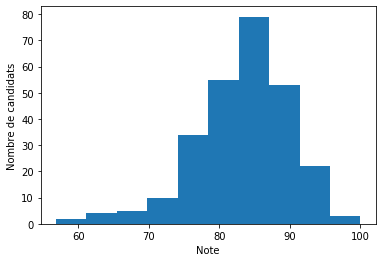

In [649]:
plt.hist(dataSmartbehaviour)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [650]:
shapiro(SmartbehaviourRetenu)

(0.9689154028892517, 0.04840885475277901)

In [651]:
shapiro(SmartbehaviourNonRetenu)

(0.9532055258750916, 7.736123734503053e-06)

In [652]:
levene(SmartbehaviourRetenu,SmartbehaviourNonRetenu,center="mean")

LeveneResult(statistic=4.207273720613192, pvalue=0.041234137416734554)

In [653]:
utestSmartbehaviour= mannwhitneyu( SmartbehaviourRetenu, SmartbehaviourNonRetenu)
utestSmartbehaviour

MannwhitneyuResult(statistic=7105.5, pvalue=0.25756677909840175)

# cooperation


In [654]:
cooperationRetenu=[]
cooperationNonRetenu=[]
dataCooperation=[]
for i in range(0,267):
    dataCooperation.append(final.iloc[i]["cooperation"])

    if (final.iloc[i]["Selected"]=="true"):
        cooperationRetenu.append(final.iloc[i]["cooperation"])
    else :cooperationNonRetenu.append(final.iloc[i]["cooperation"])

/Users/oussamasassi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/oussamasassi/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


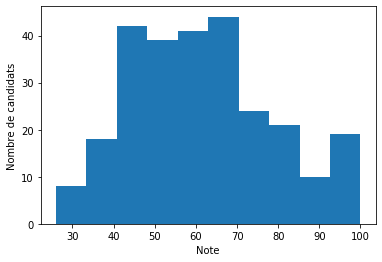

In [655]:
plt.hist(dataCooperation)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [656]:
shapiro(cooperationRetenu)

(nan, 1.0)

In [657]:
shapiro(cooperationNonRetenu)

(0.9651663303375244, 0.000133694673422724)

In [658]:
levene(cooperationRetenu,cooperationNonRetenu,center="mean")

LeveneResult(statistic=nan, pvalue=nan)

In [659]:
utestCooperation= mannwhitneyu( cooperationRetenu, cooperationNonRetenu)
utestCooperation

MannwhitneyuResult(statistic=6845.5, pvalue=0.13629618127422993)

# londonTowers

In [660]:
londonTowersRetenu=[]
londonTowersNonRetenu=[]
datalondonTowers=[]
for i in range(0,267):
    
    datalondonTowers.append(final.iloc[i]["londonTowers"])

    if (final.iloc[i]["Selected"]=="true"):
        londonTowersRetenu.append(final.iloc[i]["londonTowers"])
    else :londonTowersNonRetenu.append(final.iloc[i]["londonTowers"])

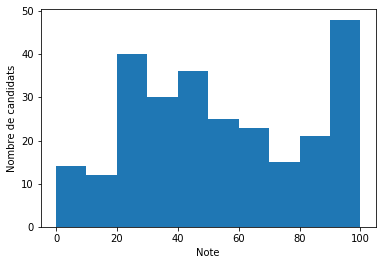

In [661]:
plt.hist(datalondonTowers)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [662]:
shapiro(londonTowersRetenu)

(nan, 1.0)

In [663]:
shapiro(londonTowersNonRetenu)

(nan, 1.0)

In [664]:
levene(londonTowersRetenu,londonTowersNonRetenu,center="mean")

LeveneResult(statistic=nan, pvalue=nan)

In [665]:
ttestlondonTowers= ttest_ind( londonTowersRetenu,londonTowersNonRetenu)
ttestlondonTowers

Ttest_indResult(statistic=nan, pvalue=nan)

# perspectiveTaking 

In [666]:
perspectiveTakingRetenu=[]
perspectiveTakingNonRetenu=[]
dataperspectiveTaking=[]
for i in range(0,267):
    dataperspectiveTaking.append(final.iloc[i]["perspectiveTaking"])

    if (final.iloc[i]["Selected"]=="true"):
        perspectiveTakingRetenu.append(final.iloc[i]["perspectiveTaking"])
    else :perspectiveTakingNonRetenu.append(final.iloc[i]["perspectiveTaking"])

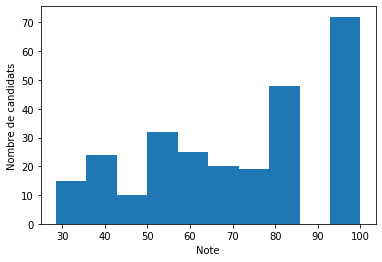

In [667]:
plt.hist(dataperspectiveTaking)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [668]:
shapiro(perspectiveTakingRetenu)

(nan, 1.0)

In [669]:
shapiro(perspectiveTakingNonRetenu)

(nan, 1.0)

In [670]:
levene(perspectiveTakingRetenu,perspectiveTakingNonRetenu,center="mean")

LeveneResult(statistic=nan, pvalue=nan)

In [671]:
ttestperspectiveTaking= ttest_ind( perspectiveTakingRetenu,perspectiveTakingNonRetenu)
ttestperspectiveTaking

Ttest_indResult(statistic=nan, pvalue=nan)

# taskSwitching2


In [672]:
taskSwitchingRetenu=[]
taskSwitchingNonRetenu=[]
dataTaskSwitching=[]
for i in range(0,267):
    dataTaskSwitching.append(final.iloc[i]["taskSwitching2"])
    if (final.iloc[i]["Selected"]=="true"):
        taskSwitchingRetenu.append(final.iloc[i]["taskSwitching2"])
    else :taskSwitchingNonRetenu.append(final.iloc[i]["taskSwitching2"])

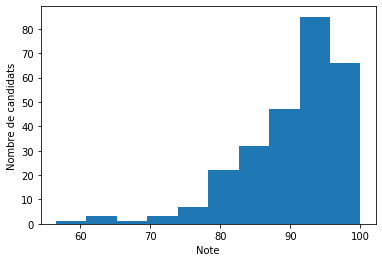

In [673]:
plt.hist(dataTaskSwitching)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [674]:
shapiro(taskSwitchingRetenu)

(0.9178107380867004, 7.504802488256246e-05)

In [675]:
shapiro(taskSwitchingNonRetenu)

(0.8728823661804199, 1.8782919664062092e-11)

In [676]:
levene(taskSwitchingRetenu,taskSwitchingNonRetenu,center="mean")

LeveneResult(statistic=4.455767738662008, pvalue=0.03572036904740764)

In [677]:
utesttaskSwitching= mannwhitneyu(taskSwitchingRetenu,taskSwitchingNonRetenu)
utesttaskSwitching

MannwhitneyuResult(statistic=7170.0, pvalue=0.2959978854716916)

# workMemory2

In [678]:
workMemoryRetenu=[]
workMemoryNonRetenu=[]
dataWorkMemory=[]
for i in range(0,267):
    dataWorkMemory.append(final.iloc[i]["workMemory2"])

    if (final.iloc[i]["Selected"]=="true"):
        workMemoryRetenu.append(final.iloc[i]["workMemory2"])
    else :workMemoryNonRetenu.append(final.iloc[i]["workMemory2"])

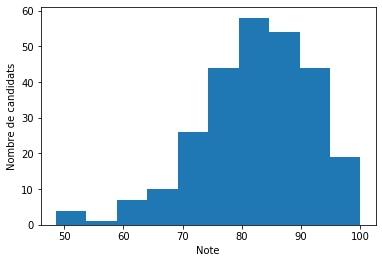

In [679]:
plt.hist(dataWorkMemory)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [680]:
shapiro(workMemoryRetenu)

(0.9122971892356873, 4.191527477814816e-05)

In [681]:
shapiro(workMemoryNonRetenu)

(0.9762229919433594, 0.0028081885538995266)

In [682]:
levene(workMemoryRetenu,workMemoryNonRetenu,center="mean")

LeveneResult(statistic=0.43792823673571996, pvalue=0.5086991206972362)

In [683]:
utestworkMemory= mannwhitneyu(workMemoryRetenu,workMemoryNonRetenu)
utestworkMemory

MannwhitneyuResult(statistic=6889.5, pvalue=0.1536895878310987)

# Adaptabilité à l'environnement, aux personnes, écoute


In [684]:
adaptabiliteRetenu=[]
adaptabiliteNonRetenu=[]
dataAdaptabilite=[]
for i in range(0,267):
    dataAdaptabilite.append(final.iloc[i]["Adaptabilité à l'environnement, aux personnes, écoute"])

    if (final.iloc[i]["Selected"]=="true"):
        adaptabiliteRetenu.append(final.iloc[i]["Adaptabilité à l'environnement, aux personnes, écoute"])
    else :adaptabiliteNonRetenu.append(final.iloc[i]["Adaptabilité à l'environnement, aux personnes, écoute"])

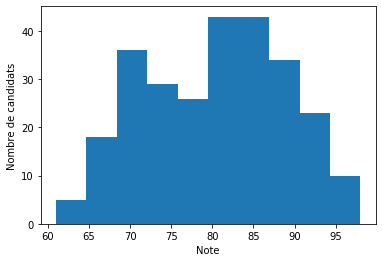

In [685]:
plt.hist(dataAdaptabilite)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [686]:
shapiro(adaptabiliteRetenu)

(0.9766680598258972, 0.15106405317783356)

In [687]:
shapiro(adaptabiliteNonRetenu)

(0.9747629165649414, 0.001830211142078042)

In [688]:
levene(adaptabiliteRetenu,adaptabiliteNonRetenu , center="mean")

LeveneResult(statistic=0.04108610023968876, pvalue=0.8395273545042163)

In [689]:
utestadaptabilite= mannwhitneyu(adaptabiliteRetenu,adaptabiliteNonRetenu)
utestadaptabilite

MannwhitneyuResult(statistic=6923.0, pvalue=0.16760711018989782)

# Anglais


In [690]:
anglaisRetenu=[]
anglaisNonRetenu=[]
dataAng=[]
for i in range(0,267):
    dataAng.append(final.iloc[i]["Anglais"])

    if (final.iloc[i]["Selected"]=="true"):
        anglaisRetenu.append(final.iloc[i]["Anglais"])
    else :anglaisNonRetenu.append(final.iloc[i]["Anglais"])

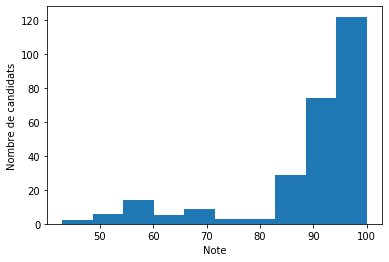

In [691]:
plt.hist(dataAng)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [692]:
shapiro(anglaisRetenu)

(0.6857879757881165, 8.52604358642095e-12)

In [693]:
shapiro(anglaisNonRetenu)

(0.7608389258384705, 3.733988840968729e-16)

In [694]:
levene(anglaisRetenu,anglaisNonRetenu,center="mean")

LeveneResult(statistic=6.890379569291438, pvalue=0.009169415682525306)

In [695]:
utestanglais= mannwhitneyu(anglaisRetenu,anglaisNonRetenu)
utestanglais

MannwhitneyuResult(statistic=6325.5, pvalue=0.02142081573301758)

# Expression écrite - connaissance CEO


In [696]:
expressionEcriteRetenu=[]
expressionEcriteNonRetenu=[]
dataExpressionEcrite=[]
for i in range(0,267):
    dataExpressionEcrite.append(final.iloc[i]["Expression écrite - connaissance CEO"])

    if (final.iloc[i]["Selected"]=="true"):
        expressionEcriteRetenu.append(final.iloc[i]["Expression écrite - connaissance CEO"])
    else :expressionEcriteNonRetenu.append(final.iloc[i]["Expression écrite - connaissance CEO"])

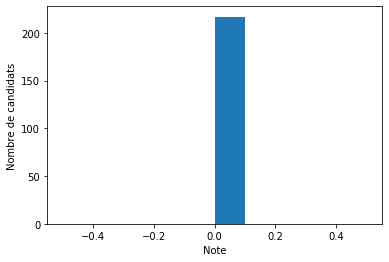

In [697]:
plt.hist(dataExpressionEcrite)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [698]:
shapiro(expressionEcriteRetenu)

(nan, 1.0)

In [699]:
shapiro(expressionEcriteNonRetenu)

(nan, 1.0)

In [700]:
levene(expressionEcriteRetenu,expressionEcriteNonRetenu,center="mean")

LeveneResult(statistic=nan, pvalue=nan)

In [701]:
ttestexpressionEcrite= ttest_ind(expressionEcriteRetenu,expressionEcriteNonRetenu)
ttestexpressionEcrite

Ttest_indResult(statistic=nan, pvalue=nan)

# Gestion du stress


In [702]:
gestionStressRetenu=[]
gestionStressNonRetenu=[]
dataStress=[]
for i in range(0,267):
    dataStress.append(final.iloc[i]["Gestion du stress"])

    if (final.iloc[i]["Selected"]=="true"):
        gestionStressRetenu.append(final.iloc[i]["Gestion du stress"])
    else :gestionStressNonRetenu.append(final.iloc[i]["Gestion du stress"])

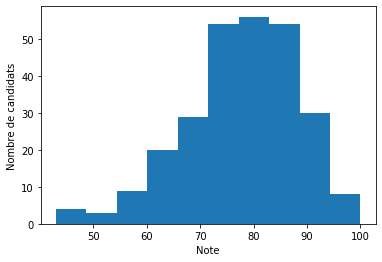

In [703]:
plt.hist(dataStress)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [704]:
shapiro(gestionStressRetenu)

(0.9694905877113342, 0.05266357958316803)

In [705]:
shapiro(gestionStressNonRetenu)

(0.9742968678474426, 0.0015992410480976105)

In [706]:
levene(gestionStressRetenu,gestionStressNonRetenu,center="mean")

LeveneResult(statistic=0.0977162220302168, pvalue=0.754833510773194)

In [707]:
utestgestionStress= mannwhitneyu(gestionStressRetenu,gestionStressNonRetenu)
utestgestionStress

MannwhitneyuResult(statistic=7115.0, pvalue=0.263474132004587)

# Leadership


In [708]:
leadershipRetenu=[]
leadershipNonRetenu=[]
dataLeadership=[]
for i in range(0,267):
    dataLeadership.append(final.iloc[i]["Leadership"])

    if (final.iloc[i]["Selected"]=="true"):
        leadershipRetenu.append(final.iloc[i]["Leadership"])
    else :leadershipNonRetenu.append(final.iloc[i]["Leadership"])

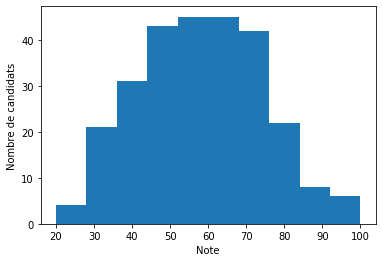

In [709]:
plt.hist(dataLeadership)


plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [710]:
shapiro(leadershipRetenu)

(0.9644927978515625, 0.02547232061624527)

In [711]:
shapiro(leadershipNonRetenu)

(0.9904168248176575, 0.24645516276359558)

In [712]:
levene(leadershipRetenu,leadershipNonRetenu,center="mean")

LeveneResult(statistic=0.3508282869222754, pvalue=0.5541496667983904)

In [713]:
ttestLeadership= ttest_ind(leadershipRetenu,leadershipNonRetenu)
ttestLeadership

Ttest_indResult(statistic=0.07417851945347094, pvalue=0.94092429984939)

# Synthèse, capacité de raisonnement


In [714]:
syntheseRetenu=[]
syntheseNonRetenu=[]
dataSynthese=[]
for i in range(0,267):
    dataSynthese.append(final.iloc[i]["Synthèse, capacité de raisonnement"])

    if (final.iloc[i]["Selected"]=="true"):
        syntheseRetenu.append(final.iloc[i]["Synthèse, capacité de raisonnement"])
    else :syntheseNonRetenu.append(final.iloc[i]["Synthèse, capacité de raisonnement"])

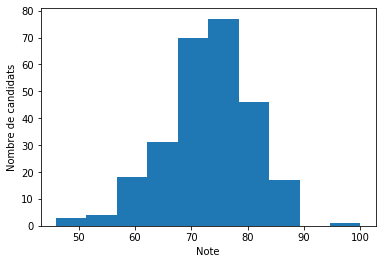

In [715]:
plt.hist(dataSynthese)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [716]:
shapiro(syntheseRetenu)

(0.9769936800003052, 0.15839333832263947)

In [717]:
shapiro(syntheseNonRetenu)

(0.987606406211853, 0.10108563303947449)

In [718]:
levene(syntheseRetenu,syntheseNonRetenu,center="mean")

LeveneResult(statistic=1.6159428138917677, pvalue=0.20477309131929547)

In [719]:
ttestSynthese= ttest_ind(syntheseRetenu,syntheseNonRetenu)
ttestSynthese

Ttest_indResult(statistic=0.46665609529025065, pvalue=0.641129354137946)

# Vivacité d'esprit, adaptabilité, flexibilité mentale


In [720]:
espritRetenu=[]
espritNonRetenu=[]
dataEsprit=[]
for i in range(0,267):
    dataEsprit.append(final.iloc[i]["Vivacité d'esprit, adaptabilité, flexibilité mentale"])

    if (final.iloc[i]["Selected"]=="true"):
        espritRetenu.append(final.iloc[i]["Vivacité d'esprit, adaptabilité, flexibilité mentale"])
    else :espritNonRetenu.append(final.iloc[i]["Vivacité d'esprit, adaptabilité, flexibilité mentale"])

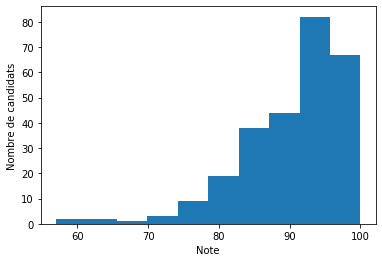

In [721]:
ttestEsprit= ttest_ind(espritRetenu,espritNonRetenu)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.hist(dataEsprit)
plt.show()

In [722]:
shapiro(espritRetenu)

(0.9085447788238525, 2.849076372513082e-05)

In [723]:
shapiro(espritNonRetenu)

(0.8702986240386963, 1.3736864944158267e-11)

In [724]:
levene(espritRetenu,espritNonRetenu,center="mean")

LeveneResult(statistic=4.380498094355827, pvalue=0.03730334853455228)

In [725]:
utestEsprit =mannwhitneyu(espritRetenu,espritNonRetenu)
utestEsprit[1]

0.2958401583661057

# Présélection 

In [726]:
preselectionRetenu=[]
preselectionNonRetenu=[]
dataPreselection=[]
for i in range(0,267):
    dataPreselection.append(final.iloc[i]["Présélection"])

    if (final.iloc[i]["Selected"]=="true"):
        preselectionRetenu.append(final.iloc[i]["Présélection"])
    else :preselectionNonRetenu.append(final.iloc[i]["Présélection"])

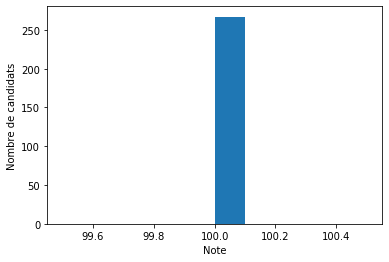

In [727]:
plt.hist(dataPreselection)
plt.xlabel('Note',fontsize=10)
plt.ylabel('Nombre de candidats',fontsize=10)
plt.show()

In [728]:
shapiro(preselectionRetenu)

(1.0, 1.0)

In [729]:
shapiro(preselectionNonRetenu)

(1.0, 1.0)

In [730]:
levene(preselectionRetenu,preselectionNonRetenu,center="mean")

LeveneResult(statistic=nan, pvalue=nan)

In [731]:
ttestPreselection= ttest_ind(preselectionRetenu,preselectionNonRetenu)
ttestPreselection

Ttest_indResult(statistic=nan, pvalue=nan)

# New Function

In [788]:
def verification (data1,data2):
    if((str(ttest_ind(data1,data2)[1])=="nan") or (str(ttest_ind(data1,data2,equal_var="False")[1])=="nan") ):
        return(False)
    else : return(True)
    
    
    

In [927]:
selected=[]
noSelected=[]
itemSelected=[]
itemNoSelected=[]
pSeuil=0.05
testResult=0
test=""
def analyse(data,item):
    selected=data[data["Selected"]=="true"]
    itemSelected=selected[item]
    noSelected=data[data["Selected"]=="false"]
    itemNoSelected=noSelected[item]
    
    
    verif=verification(itemSelected,itemNoSelected)
    if (verif==True):
        plt.title(item)
        plt.hist(data[item])
        plt.xlabel('Note',fontsize=10)
        plt.ylabel('Nombre de candidats',fontsize=10)
        plt.show()
       
        plt.title(str(item)+":"+"Candidats Retenus VS Candidats Non Retenus")
        plt.hist(itemSelected, alpha = 0.5, label='Candidats Retenus')
        plt.hist(itemNoSelected,alpha = 0.3, label=' Candidats Non Retenus')
        plt.legend(loc="upper left")
        plt.xlabel('Note',fontsize=10)
        plt.ylabel('Nombre de candidats',fontsize=10)
        plt.show()
    
        plt.title(str(item)+" :"+"Répartition des résultats des deux groupes")
        p=plt.boxplot([itemSelected,itemNoSelected],labels=["Candidats Retenus","Candidats Non Retenus"])
        plt.show(p)
    
        print("test de normalité pour la partie des candidats retenus"+str(shapiro(itemSelected)))
        print("test de normalité pour la partie des candidats non retenus"+str(shapiro(itemNoSelected)))
        if ((shapiro(itemSelected)[1] >pSeuil) and (shapiro(itemNoSelected)[1] >pSeuil) ):
            print ("les deux parties de "+item+ " suivent la lois normal")
            print("le résultat du test d'égalité des variances  " +str(levene(itemSelected,itemNoSelected,center="mean")))
            if (levene(itemSelected,itemNoSelected,center="mean")[1]>pSeuil):
                print("l'égalité de variance est verifiée pour les deux parties donc on applique le test de Student")
                testResult= ttest_ind(itemSelected,itemNoSelected)
                print("résulat test de Student"+str(testResult))
                test="T-test"

            else:
                print("l'égalité de variance n'est pas verifiée pour les deux parties donc on applique le test de Welch")
                testResult= ttest_ind(itemSelected,itemNoSelected,equal_var="False")
                print("résulat test de Welch"+ str(testResult))
                test="Welch’s t-test"

            
            
        else :
            print ("les deux parties de "+item+ " ne suivent pas suivent la lois normal donc on applique le Test U")
            testResult =mannwhitneyu(itemSelected,itemNoSelected)
            print("résultat de Test U"+str(testResult))
            test="Mann Whitney U test"
    
        return(testResult,test)
    else:
        testResult=float('NaN'),float('NaN')
        test=""
        return(testResult,test)
            



In [928]:
dataFrame = pd.DataFrame(columns = ['Game/Questionnaire',"Statistic test","Statistic","p-value"])  
dataFrameAxes = pd.DataFrame(columns = ['Axe',"Statistic test","Statistic","p-value"])  

In [929]:
axes=[]
for i in result:
    axes.append(i)

In [930]:
items=[]
for i in final :
    if(i!="CandidateId" and i!="Selected" and i not in axes):
        items.append(i)

In [931]:
def test (axe,outputData):
    res,test=analyse(final,axe)
    outputData.loc[-1]=[axe,test,res[0],res[1]]
    outputData.index=outputData.index+1
        
        
    

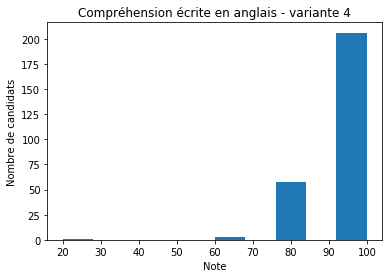

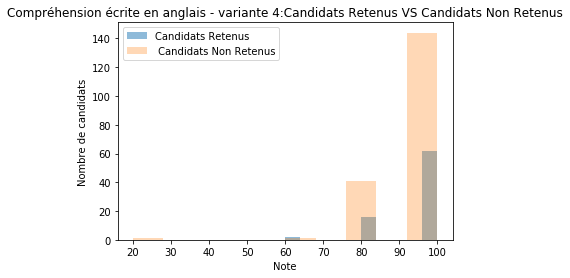

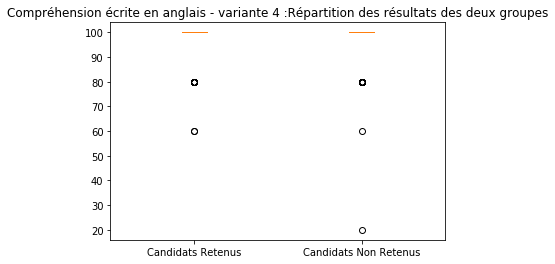

test de normalité pour la partie des candidats retenus(0.5428114533424377, 2.1598477875444354e-14)
test de normalité pour la partie des candidats non retenus(0.5025969743728638, 1.0008369812403982e-22)
les deux parties de Compréhension écrite en anglais - variante 4 ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=7467.0, pvalue=0.48816239703160647)


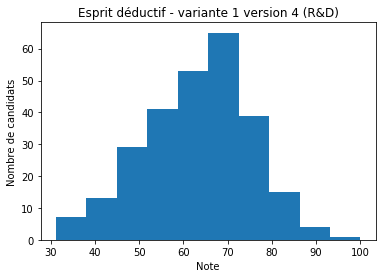

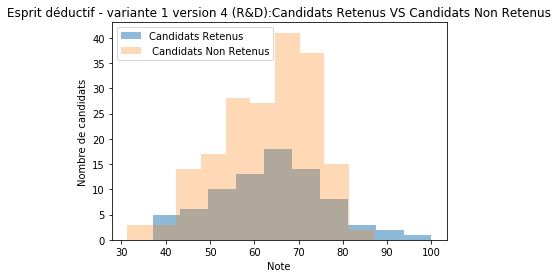

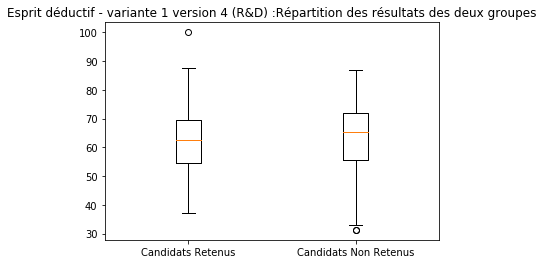

test de normalité pour la partie des candidats retenus(0.9871163964271545, 0.606168806552887)
test de normalité pour la partie des candidats non retenus(0.9782390594482422, 0.005140756722539663)
les deux parties de Esprit déductif - variante 1 version 4 (R&D) ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=7201.5, pvalue=0.31522868123107906)


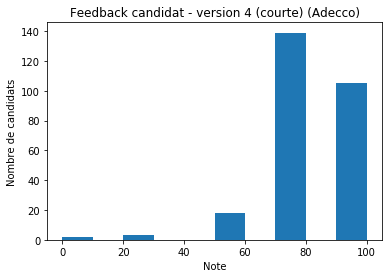

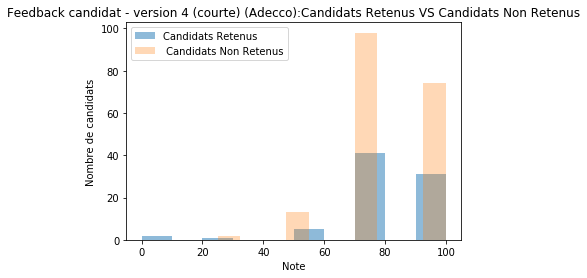

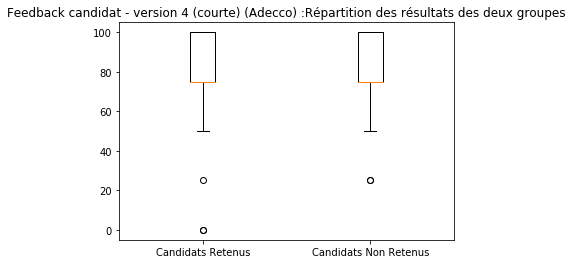

test de normalité pour la partie des candidats retenus(0.726601243019104, 6.619331471835466e-11)
test de normalité pour la partie des candidats non retenus(0.7629162669181824, 4.3972037272680255e-16)
les deux parties de Feedback candidat - version 4 (courte) (Adecco) ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=7317.5, pvalue=0.37684327490619585)


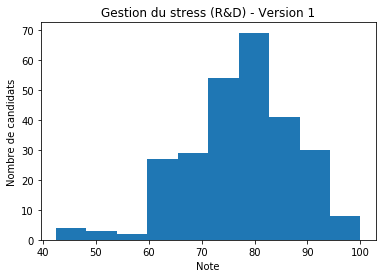

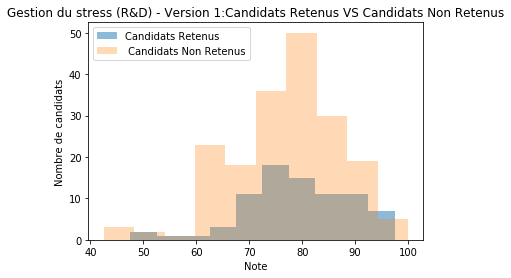

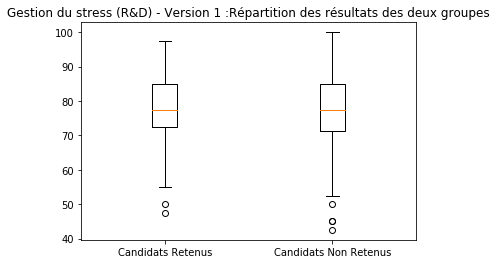

test de normalité pour la partie des candidats retenus(0.969456672668457, 0.05240272358059883)
test de normalité pour la partie des candidats non retenus(0.9747586250305176, 0.001827926840633154)
les deux parties de Gestion du stress (R&D) - Version 1 ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=7115.0, pvalue=0.263474132004587)


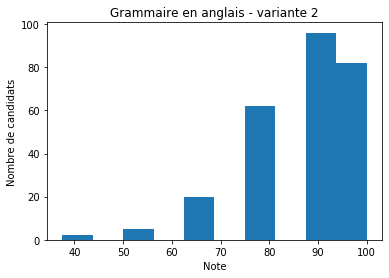

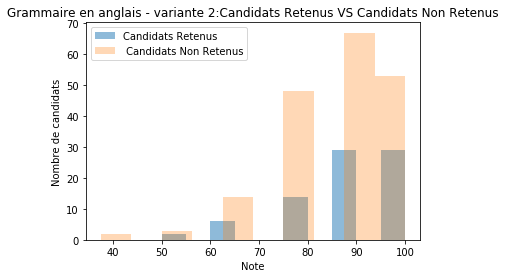

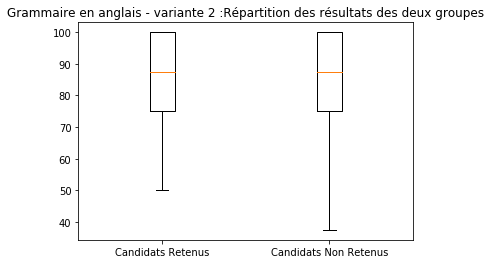

test de normalité pour la partie des candidats retenus(0.8387051820755005, 6.889617765182265e-08)
test de normalité pour la partie des candidats non retenus(0.8659214973449707, 8.16161808275817e-12)
les deux parties de Grammaire en anglais - variante 2 ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=6710.0, pvalue=0.08161160960383418)


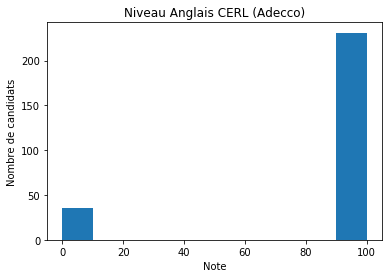

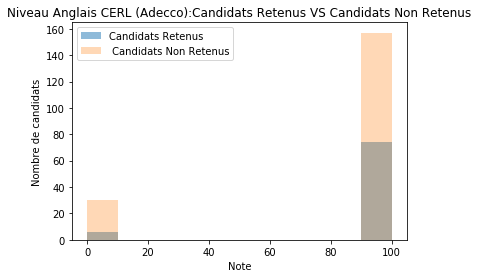

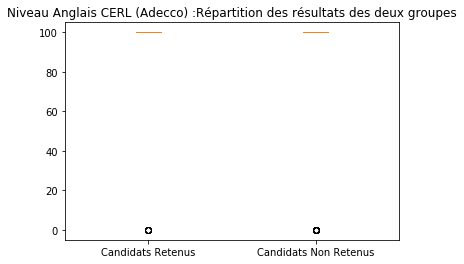

test de normalité pour la partie des candidats retenus(0.28974252939224243, 8.241184726434176e-18)
test de normalité pour la partie des candidats non retenus(0.440809965133667, 6.874344553957591e-24)
les deux parties de Niveau Anglais CERL (Adecco) ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=6841.0, pvalue=0.03093147860272651)


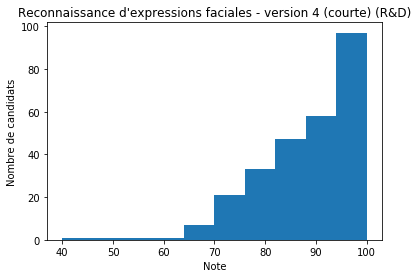

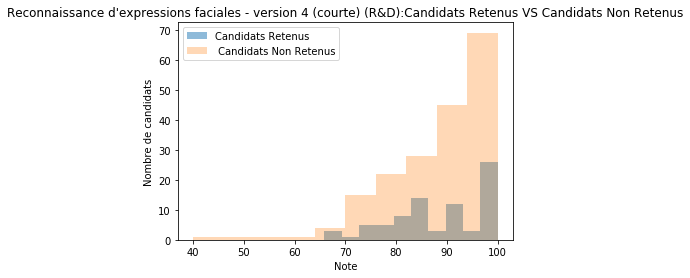

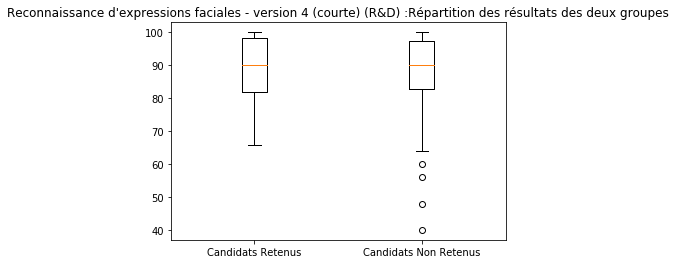

test de normalité pour la partie des candidats retenus(0.9246662259101868, 0.0001590625470271334)
test de normalité pour la partie des candidats non retenus(0.8828663229942322, 6.558381615562325e-11)
les deux parties de Reconnaissance d'expressions faciales - version 4 (courte) (R&D) ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=7264.5, pvalue=0.3545699438028219)


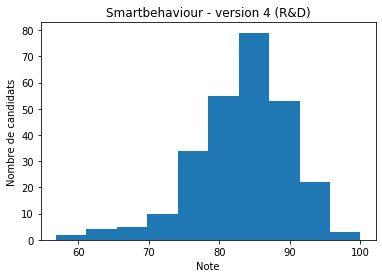

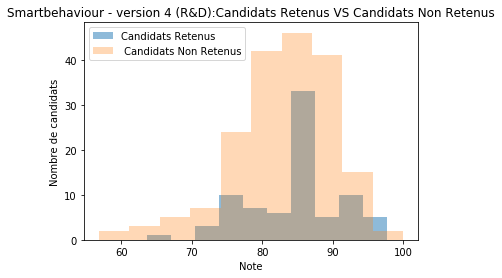

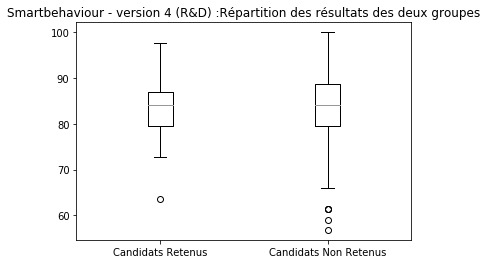

test de normalité pour la partie des candidats retenus(0.9689154028892517, 0.04840885475277901)
test de normalité pour la partie des candidats non retenus(0.9532055258750916, 7.736123734503053e-06)
les deux parties de Smartbehaviour - version 4 (R&D) ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=7105.5, pvalue=0.25756677909840175)


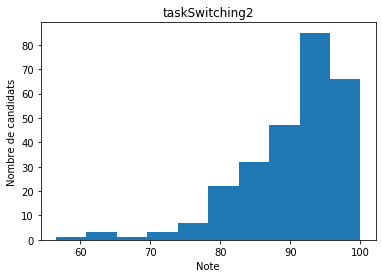

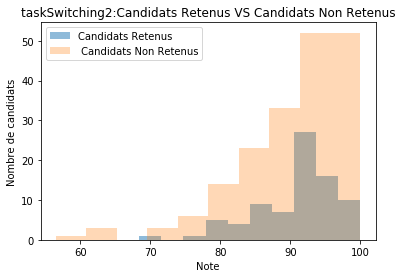

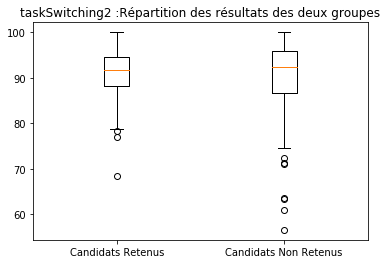

test de normalité pour la partie des candidats retenus(0.9178107380867004, 7.504802488256246e-05)
test de normalité pour la partie des candidats non retenus(0.8728823661804199, 1.8782919664062092e-11)
les deux parties de taskSwitching2 ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=7170.0, pvalue=0.2959978854716916)


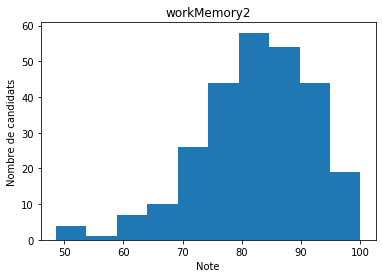

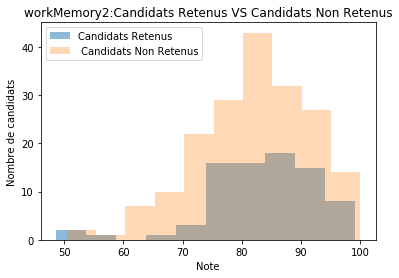

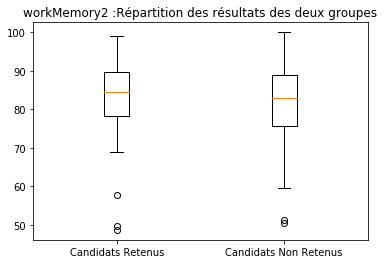

test de normalité pour la partie des candidats retenus(0.9122971892356873, 4.191527477814816e-05)
test de normalité pour la partie des candidats non retenus(0.9762229919433594, 0.0028081885538995266)
les deux parties de workMemory2 ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=6889.5, pvalue=0.1536895878310987)


In [932]:
for i in items:
    test(i,dataFrame)

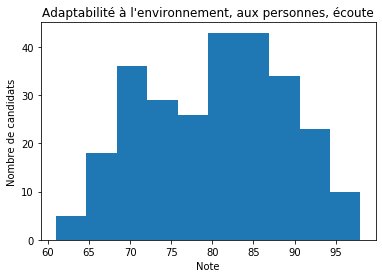

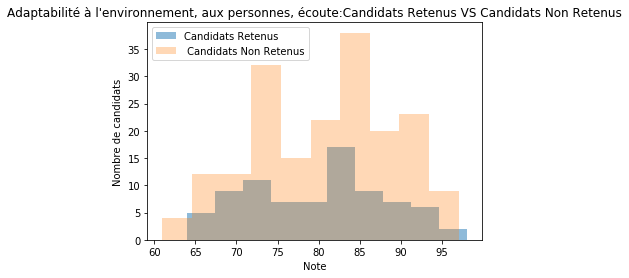

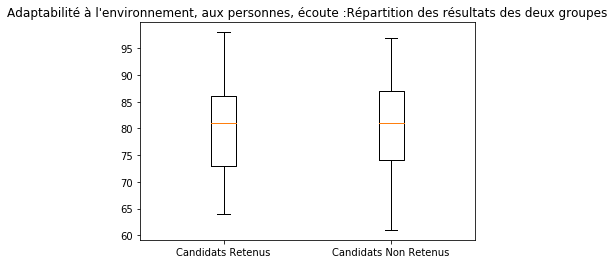

test de normalité pour la partie des candidats retenus(0.9766680598258972, 0.15106405317783356)
test de normalité pour la partie des candidats non retenus(0.9747629165649414, 0.001830211142078042)
les deux parties de Adaptabilité à l'environnement, aux personnes, écoute ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=6923.0, pvalue=0.16760711018989782)


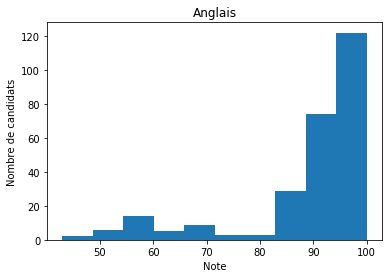

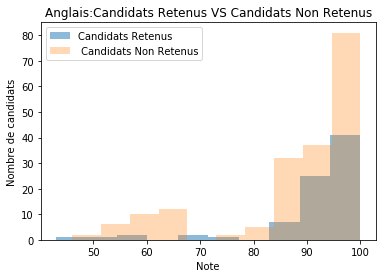

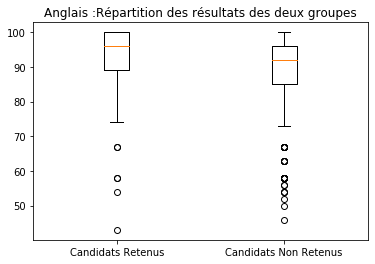

test de normalité pour la partie des candidats retenus(0.6857879757881165, 8.52604358642095e-12)
test de normalité pour la partie des candidats non retenus(0.7608389258384705, 3.733988840968729e-16)
les deux parties de Anglais ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=6325.5, pvalue=0.02142081573301758)


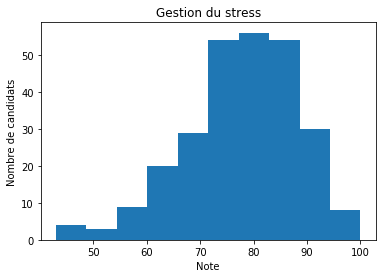

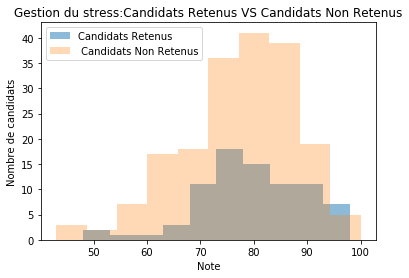

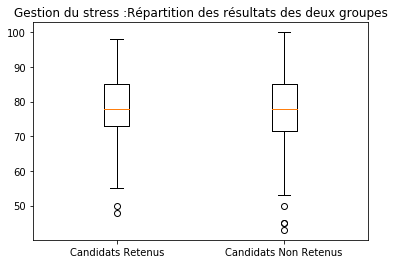

test de normalité pour la partie des candidats retenus(0.9694905877113342, 0.05266357958316803)
test de normalité pour la partie des candidats non retenus(0.9742968678474426, 0.0015992410480976105)
les deux parties de Gestion du stress ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=7115.0, pvalue=0.263474132004587)


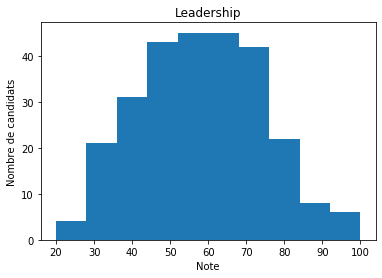

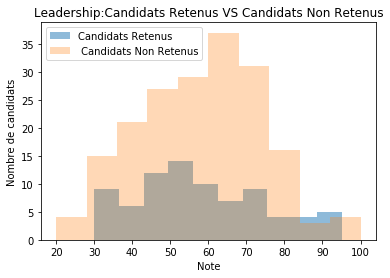

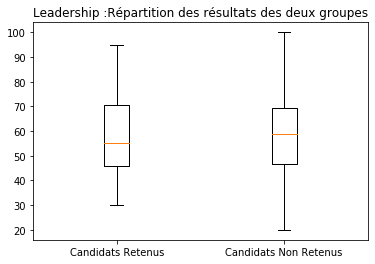

test de normalité pour la partie des candidats retenus(0.9644927978515625, 0.02547232061624527)
test de normalité pour la partie des candidats non retenus(0.9904168248176575, 0.24645516276359558)
les deux parties de Leadership ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=7320.5, pvalue=0.391606150333417)


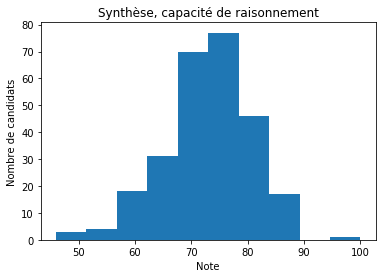

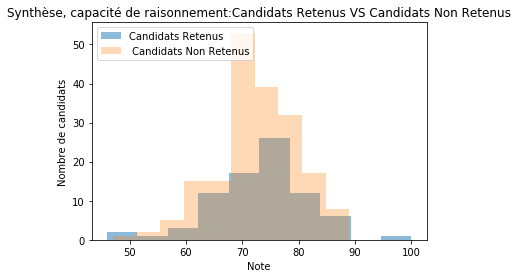

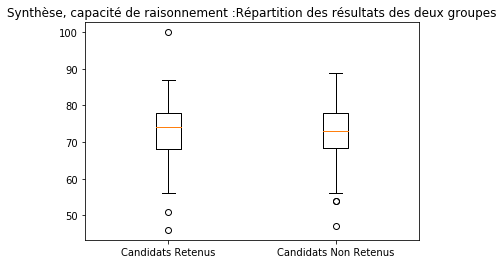

test de normalité pour la partie des candidats retenus(0.9769936800003052, 0.15839333832263947)
test de normalité pour la partie des candidats non retenus(0.987606406211853, 0.10108563303947449)
les deux parties de Synthèse, capacité de raisonnement suivent la lois normal
le résultat du test d'égalité des variances  LeveneResult(statistic=1.6159428138917677, pvalue=0.20477309131929547)
l'égalité de variance est verifiée pour les deux parties donc on applique le test de Student
résulat test de StudentTtest_indResult(statistic=0.46665609529025065, pvalue=0.641129354137946)


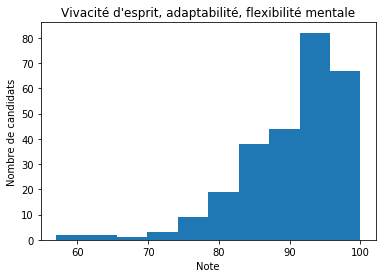

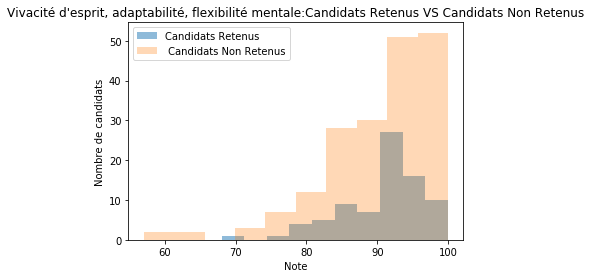

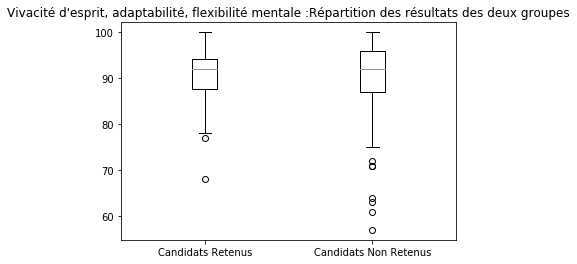

test de normalité pour la partie des candidats retenus(0.9085447788238525, 2.849076372513082e-05)
test de normalité pour la partie des candidats non retenus(0.8702986240386963, 1.3736864944158267e-11)
les deux parties de Vivacité d'esprit, adaptabilité, flexibilité mentale ne suivent pas suivent la lois normal donc on applique le Test U
résultat de Test UMannwhitneyuResult(statistic=7170.0, pvalue=0.2958401583661057)


In [933]:
for i in axes:
    test(i,dataFrameAxes)

In [934]:
dataFrame=dataFrame.dropna()
dataFrame


Game/Questionnaire       Statistic test  \
14       Compréhension écrite en anglais - variante 4  Mann Whitney U test   
13       Esprit déductif - variante 1 version 4 (R&D)  Mann Whitney U test   
12    Feedback candidat - version 4 (courte) (Adecco)  Mann Whitney U test   
11                Gestion du stress (R&D) - Version 1  Mann Whitney U test   
10                  Grammaire en anglais - variante 2  Mann Whitney U test   
9                        Niveau Anglais CERL (Adecco)  Mann Whitney U test   
6   Reconnaissance d'expressions faciales - versio...  Mann Whitney U test   
5                    Smartbehaviour - version 4 (R&D)  Mann Whitney U test   
1                                      taskSwitching2  Mann Whitney U test   
0                                         workMemory2  Mann Whitney U test   

    Statistic   p-value  
14     7467.0  0.488162  
13     7201.5  0.315229  
12     7317.5  0.376843  
11     7115.0  0.263474  
10     6710.0  0.081612  
9      6841.0  0.030931  
6      7264.5  0.354570  
5      7105.5  0.257567  
1      7170.0  0.295998  
0      6889.5  0.153690

In [935]:
dataFrameAxes=dataFrameAxes.dropna()
dataFrameAxes

Axe       Statistic test  \
8  Adaptabilité à l'environnement, aux personnes,...  Mann Whitney U test   
7                                            Anglais  Mann Whitney U test   
4                                  Gestion du stress  Mann Whitney U test   
3                                         Leadership  Mann Whitney U test   
2                 Synthèse, capacité de raisonnement               T-test   
1  Vivacité d'esprit, adaptabilité, flexibilité m...  Mann Whitney U test   

     Statistic   p-value  
8  6923.000000  0.167607  
7  6325.500000  0.021421  
4  7115.000000  0.263474  
3  7320.500000  0.391606  
2     0.466656  0.641129  
1  7170.000000  0.295840